In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import netCDF4
import properscoring as ps

import pickle

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FixedLocator
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as animation

import seaborn as sns
from scipy.stats import norm, chi2
import calendar


from gp_mjo.models.empgp_mjo_model import EmpGPMJO
from gp_mjo.models.empgp_mjo_pred import EmpGPMJOPred
from gp_mjo.models.nn_models import FFNNModel

# Data

## MJO from S2S

In [2]:
# Path to the folder containing .nc files
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
dir_names = ["ecmwf", "bom", "cnrm", "eccc", "ecmwf_txt"] #["ecmwf", "ecmwf_txt", "bom", "cnrm"]

s2s_data = {}
for dir_name in dir_names:
    folder_path = os.path.join(parent_dir, "data", dir_name)

    if dir_name == 'ecmwf_txt':
        load_path = os.path.join(folder_path, 'ecmwf_dict.pkl')
        with open(load_path, 'rb') as f:
            loaded_dict = pickle.load(f)
        s2s_data['ecmwf_txt'] = loaded_dict
    else:

        # Get a list of all .nc files in the folder
        nc_files_path = [f for f in os.listdir(folder_path) if f.endswith('.nc')]

        data_arrays = {}
        for nc_file in nc_files_path:
            file_path = os.path.join(folder_path, nc_file)
            
            # Open the NetCDF file
            dataset = netCDF4.Dataset(file_path, 'r')
            
            file_data = {}
            # Loop through all variables in the dataset
            for var_name in dataset.variables.keys():
                data_array = np.array(dataset.variables[var_name][:]) # Read the data and convert it to a numpy array
                if var_name == 'S':
                    data_array -= 6940 # 1979-01-01 - 1960-01-01 = 6940 days
                if var_name == 'hdate':
                    data_array -= 228 # 1979-01-01 - 1960-01-01 = 228 months
                if var_name in ['S', 'L', 'M', 'hdate']: # convert to integer
                    data_array = data_array.astype(int)
                file_data[var_name] = data_array # Store the data array in the file's dictionary

            data_arrays[nc_file] = file_data    
            dataset.close()

        s2s_data[dir_name] = data_arrays

        # remove NaN
        if dir_name in ['ecmwf', 'eccc']:
            remove_ids = np.argwhere( np.isnan( s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'][9][:, 0] ) ).squeeze() #'hdate' = 9, 10,...,1, set lead_time=0
            s_axis = 1
        elif dir_name in ['bom', 'cnrm']:
            remove_ids = np.argwhere( np.isnan( s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'][:, 0] ) ).squeeze()
            s_axis = 0
        
        s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'] = np.delete(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'], obj=remove_ids, axis=s_axis)
        s2s_data[dir_name]['ensemble_mean_rmm2.nc']['RMM2'] = np.delete(s2s_data[dir_name]['ensemble_mean_rmm2.nc']['RMM2'], obj=remove_ids, axis=s_axis)
        
        s2s_data[dir_name]['ensembles_rmm1.nc']['RMM1'] = np.delete(s2s_data[dir_name]['ensembles_rmm1.nc']['RMM1'], obj=remove_ids, axis=s_axis)
        s2s_data[dir_name]['ensembles_rmm2.nc']['RMM2'] = np.delete(s2s_data[dir_name]['ensembles_rmm2.nc']['RMM2'], obj=remove_ids, axis=s_axis)

        for nc_file in nc_files_path:
            s2s_data[dir_name][nc_file]['S'] = np.delete(s2s_data[dir_name][nc_file]['S'], obj=remove_ids, axis=0)


# Now `data_arrays` dictionary contains numpy arrays for each .nc file
for dir_name, variables in s2s_data.items():
    print(f"{dir_name}: {variables.keys()}")



# Example: Accessing the data from a specific file
example_dir_name =  'ecmwf' # ['bom', 'cnrm', 'ecmwf']

example_dir = s2s_data[example_dir_name]
if example_dir_name == 'ecmwf_txt':
    filenames = ['ensemble_mean', 'ensembles']
else:
    filenames = ['ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc', 'ensembles_rmm2.nc']

for filename in filenames:
    variables = list(example_dir[filename].keys())

    for variable in variables:
        example_data = example_dir[filename][variable]
        print(f"Data from {filename}, Variable: {variable}, Shape: {example_data.shape}")

ecmwf: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
bom: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
cnrm: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
eccc: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
ecmwf_txt: dict_keys(['ensemble_mean', 'ensembles'])
Data from ensemble_mean_rmm1.nc, Variable: hdate, Shape: (29,)
Data from ensemble_mean_rmm1.nc, Variable: S, Shape: (920,)
Data from ensemble_mean_rmm1.nc, Variable: L, Shape: (46,)
Data from ensemble_mean_rmm1.nc, Variable: RMM1, Shape: (29, 920, 46)
Data from ensemble_mean_rmm2.nc, Variable: L, Shape: (46,)
Data from ensemble_mean_rmm2.nc, Variable: hdate, Shape: (29,)
Data from ensemble_mean_rmm2.nc, Variable: S, Shape: (920,)
Data from ensemble_mean_rmm2.nc, Variable: RMM2, Shape: (29, 920, 46)
Dat

### Make ECMWF_txt start from Jan 3, 2012 to Jan 10, 2017 and BOM start from Sept 1, 2006 to Dec 26, 2013

In [3]:
#####################################
# ECMWF_txt
#####################################
cut_index = 1260
for key in s2s_data['ecmwf_txt']['ensemble_mean'].keys():
    s2s_data['ecmwf_txt']['ensemble_mean'][key] = s2s_data['ecmwf_txt']['ensemble_mean'][key][cut_index:]

for key in s2s_data['ecmwf_txt']['ensembles'].keys():
    s2s_data['ecmwf_txt']['ensembles'][key] = s2s_data['ecmwf_txt']['ensembles'][key][cut_index:]


#####################################
# BOM
#####################################
cut_index = -528  # or 2233
# List of paths and corresponding keys to slice
paths_and_keys = [
    ('ensemble_mean_rmm1.nc', 'RMM1'),
    ('ensemble_mean_rmm1.nc', 'S'),
    ('ensemble_mean_rmm2.nc', 'RMM2'),
    ('ensemble_mean_rmm2.nc', 'S'),
    ('ensembles_rmm1.nc', 'RMM1'),
    ('ensembles_rmm1.nc', 'S'),
    ('ensembles_rmm2.nc', 'RMM2'),
    ('ensembles_rmm2.nc', 'S')
]

# Iterate over the paths and keys to apply the slicing
for path, key in paths_and_keys:
    s2s_data['bom'][path][key] = s2s_data['bom'][path][key][cut_index:]

## MJO from CAWCR (http://www.bom.gov.au/climate/mjo/)

In [4]:
npzfile = np.load('../data/obs/mjo_new_data.npz', allow_pickle=True)
print(npzfile.files)
print(npzfile['RMM1'].shape)

data_names = npzfile.files + ['id']
n_files = len(data_names)

entire_npzfile = {}
for i, data_name in enumerate(data_names):
    if i < n_files-1:
        entire_npzfile[data_name] = npzfile[data_name]
    if i == n_files-1:
        entire_npzfile[data_name] = np.arange(len(npzfile['RMM1']))

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
(16624,)


In [5]:
# remove the ECMWF forecasts that initialized with amplitude < 1
def remove_nomjo(s2s_data, npzfile):
    start_ids = s2s_data['ecmwf']['ensemble_mean_rmm1.nc']['S']
    indices_to_delete = [i for i, start_id in enumerate(start_ids) if npzfile['amplitude'][start_id-1] < 1]

    for key in ['ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc', 'ensembles_rmm2.nc']:
        s2s_data['ecmwf'][key]['S'] = np.delete(s2s_data['ecmwf'][key]['S'], indices_to_delete, axis=0)
        rmm_key = 'RMM1' if 'rmm1' in key else 'RMM2'
        s2s_data['ecmwf'][key][rmm_key] = np.delete(s2s_data['ecmwf'][key][rmm_key], indices_to_delete, axis=1)

    start_ids = s2s_data['ecmwf_txt']['ensemble_mean']['S']
    init_amplitude = s2s_data['ecmwf_txt']['ensemble_mean']['Amplitude(0)'][:,0]
    indices_to_delete = [i for i, start_id in enumerate(start_ids) if init_amplitude[i] < 1]
    for key in ['ensemble_mean', 'ensembles']:
        for sub_key in s2s_data['ecmwf_txt'][key].keys():
            s2s_data['ecmwf_txt'][key][sub_key] = np.delete( s2s_data['ecmwf_txt'][key][sub_key], indices_to_delete, axis=0 )

# remove_nomjo(s2s_data=s2s_data, npzfile=entire_npzfile)

## Plot of data

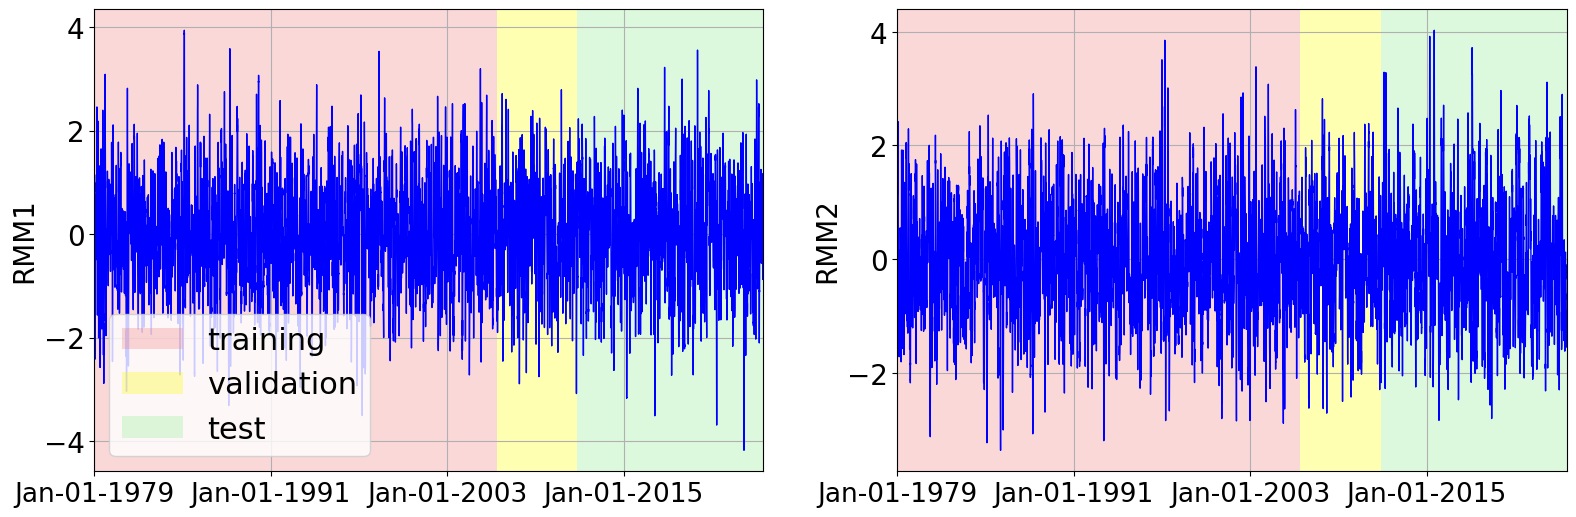

In [6]:
plt.rc('xtick', labelsize=19)  # fontsize of the tick labels
plt.rc('ytick', labelsize=20)  # fontsize of the tick labels

entire_years = entire_npzfile['year'].astype('int')
entire_months = entire_npzfile['month'].astype('int')
entire_days = entire_npzfile['day'].astype('int')
entire_df = pd.DataFrame({'year': entire_years,
                'month': entire_months,
                'day': entire_days})
entire_df_dates = pd.to_datetime(entire_df[["year", "month", "day"]], format="%Y-%m-%d")
entire_dates = pd.date_range(entire_df_dates[0], periods=len(npzfile['year']), freq='1D')

n = 10000
v = 2000
m = 5000

fig, axs = plt.subplots(1, 2, figsize=(9.5*2,6))
for k,rmm in enumerate(['RMM1','RMM2']):
    axs[k].plot(entire_dates, entire_npzfile[rmm], color='blue', linewidth=1)
    axs[k].axvspan(entire_dates[0], entire_dates[n], facecolor='lightcoral', alpha=0.3, label='training')
    axs[k].axvspan(entire_dates[n], entire_dates[n+v], facecolor='yellow', alpha=0.3, label='validation')
    axs[k].axvspan(entire_dates[n+v], entire_dates[-1], facecolor='lightgreen', alpha=0.3, label='test')


    axs[k].xaxis.set_major_locator(mdates.YearLocator(base=1))
    axs[k].margins(x=0) # so that the axis starts at the minimum date
    axs[k].set_xticks(axs[k].get_xticks()[::12]) # only show one every 10 years
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
    axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
    axs[k].set_ylabel(rmm, fontsize=20)
    axs[k].grid()

    axs[0].legend(fontsize=22)

plt.show()

# Forecast

## Entire

### Time Series

test ids of GP model and selected S2S data are Equal! Continue...


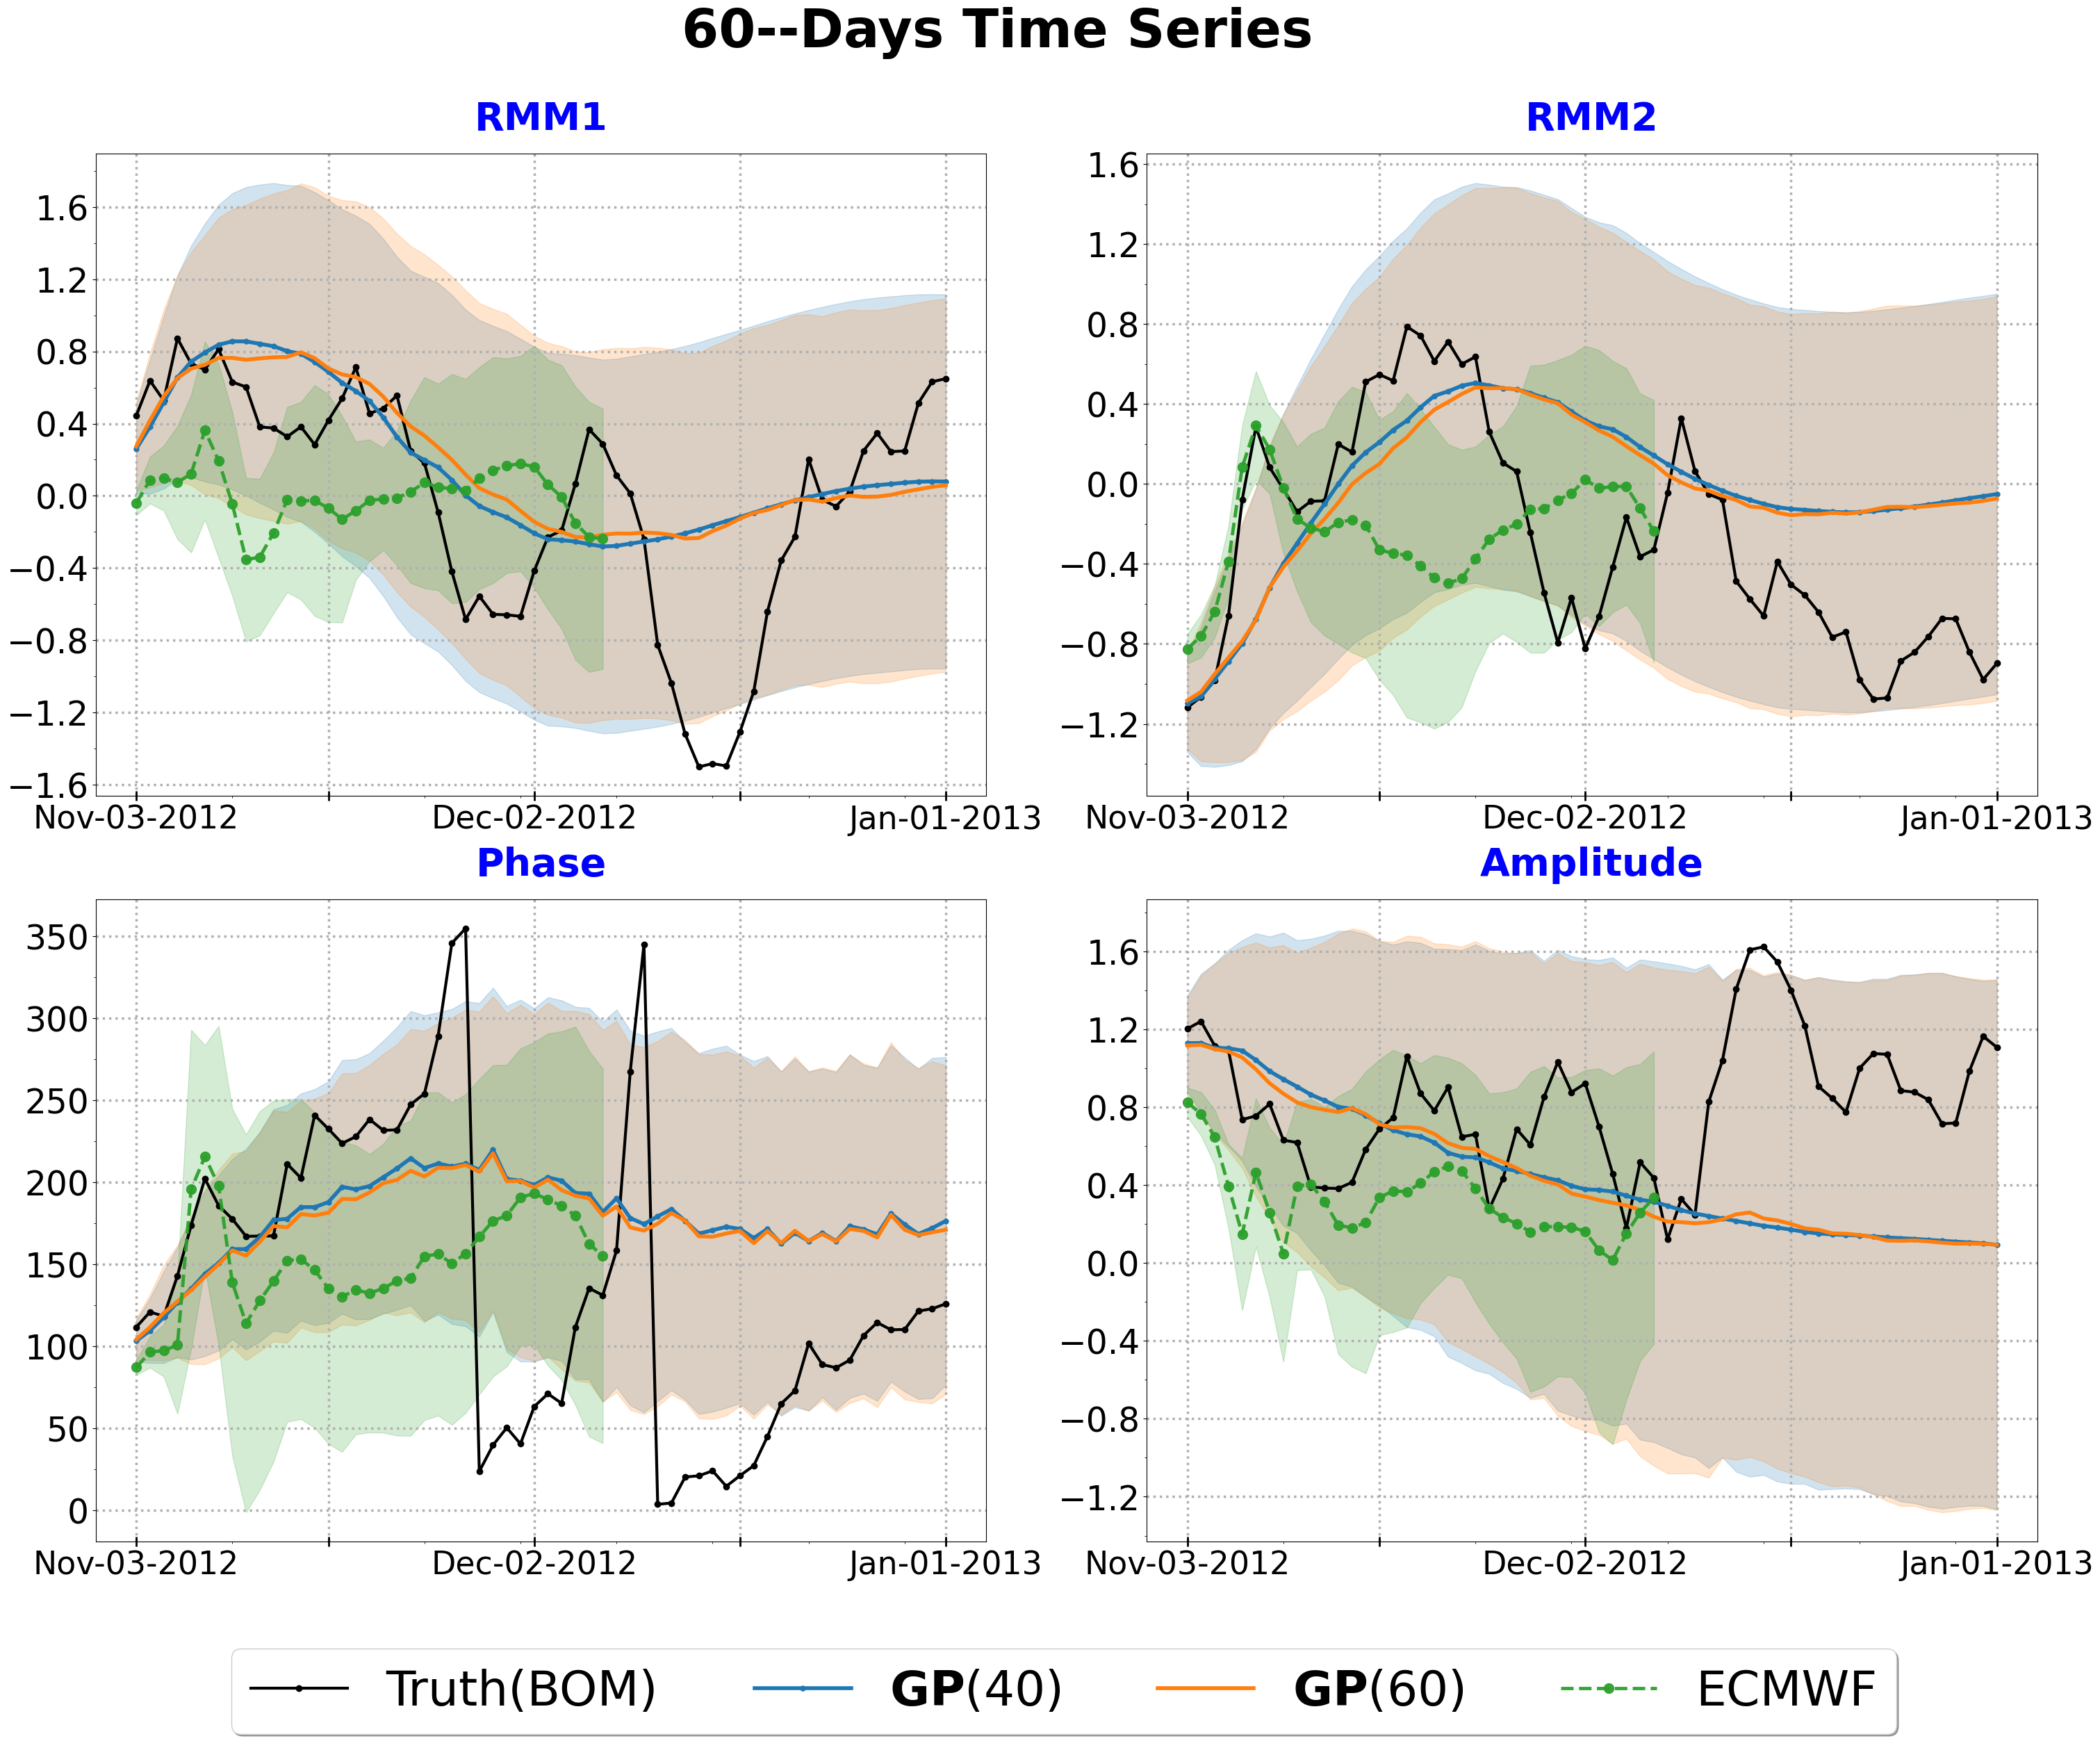

test ids of GP model and selected S2S data are Equal! Continue...


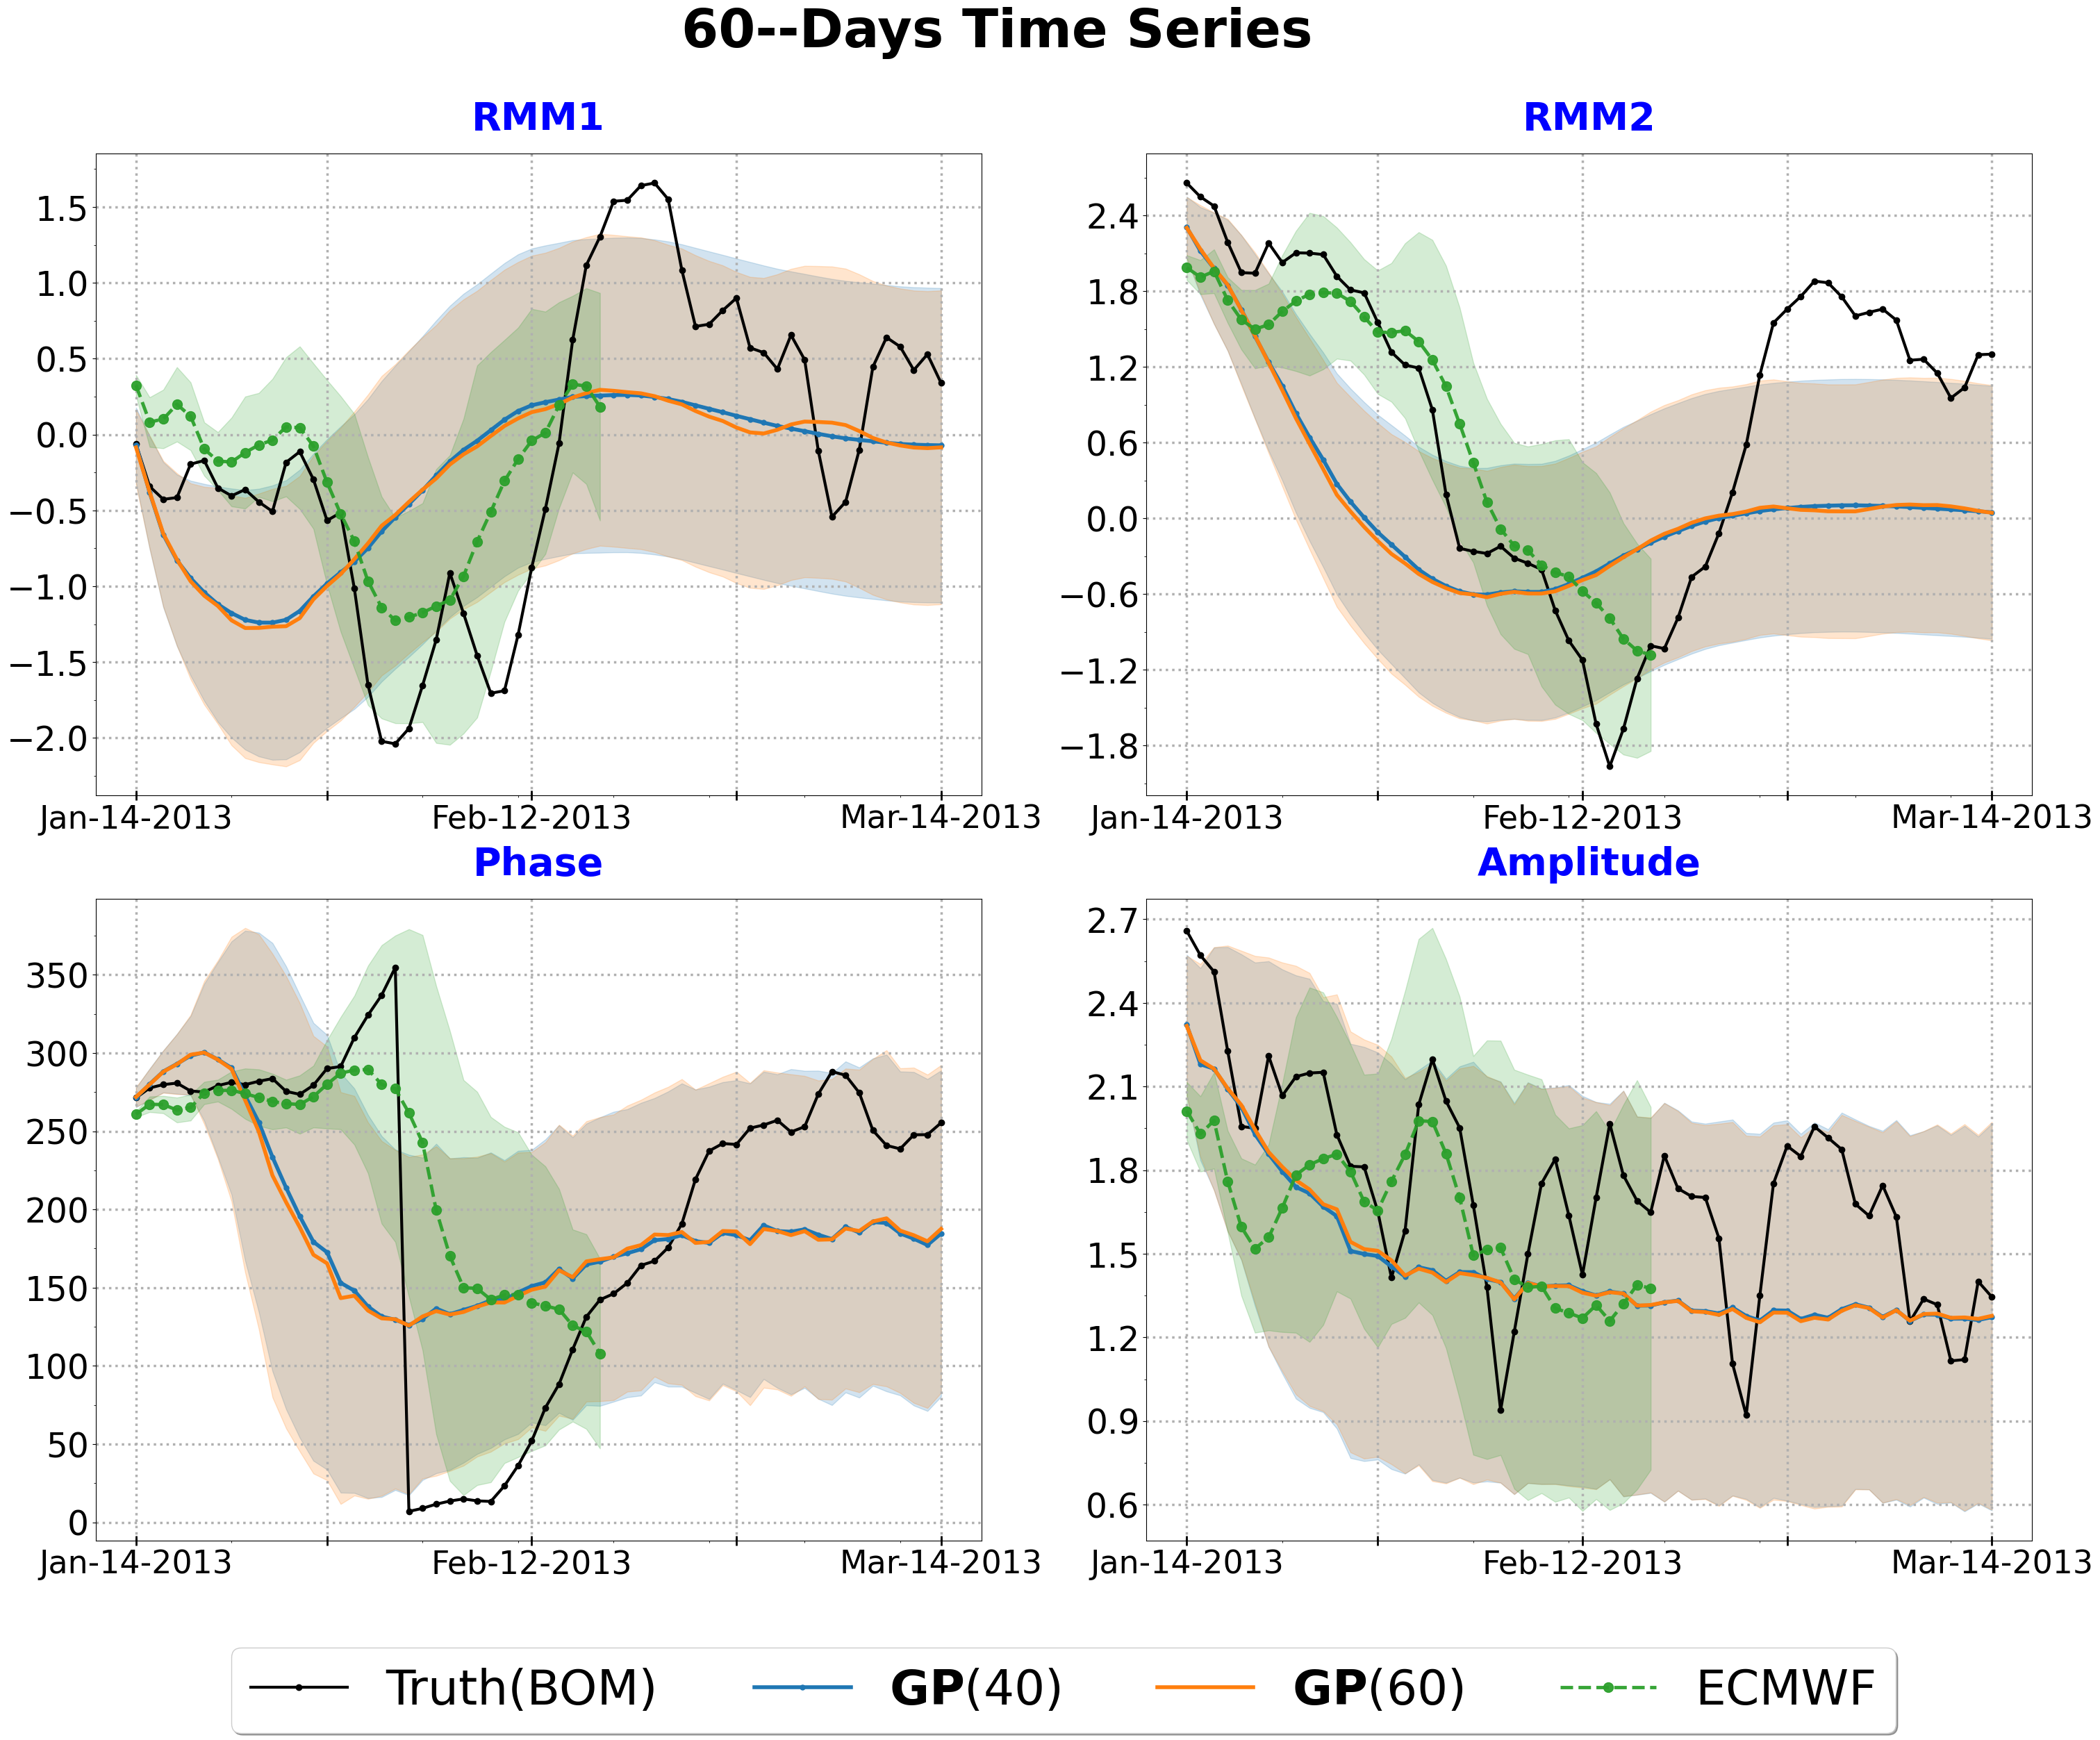

In [6]:
# dir_names = ['ecmwf_txt', 'bom', 'cnrm']
dir_names = ['ecmwf_txt']

dir_lens = [0]* len(dir_names)
for i, dir_name in enumerate(dir_names):
    if dir_name == 'ecmwf_txt':
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean']['S'])
    else:
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['S'])

min_dir_len = min(dir_lens) # 528
min_dir_name = dir_names[dir_lens.index(min_dir_len)] # 'cnrm'


widths = [40,60]
n = 10000
v = 2000
m = 5000
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 2000
pred_id = -2 # 1347, 1367

Ns = 1000
seed = 99
plot_ensembles=False
angle_mean_from_samples = True
amplitude_mean_from_samples = True


# choose_dir_name = 'ecmwf'
for choose_dir_name in dir_names:
    emp_pred_model = EmpGPMJOPred(npzfile=entire_npzfile, s2s_data=s2s_data, 
                    choose_dir_name=choose_dir_name, widths=widths,
                    n=n, v=v, m=m, lead_time=lead_time, n_pred=n_pred,
                    start_train=start_train, n_offset=n_offset, min_dir_len=min_dir_len)
    emp_pred_model.pred(test_on_choose_dir=True, test_ids=None)
    emp_pred_model.add_s2s(dir_names=dir_names, hdate_id=19, n_pred=n_pred)
    if dir_name == 'ecmwf_txt':
        for pred_id in [1347, 1368]:
            amplitude_mean_from_samples = False if pred_id in [1347,1348] else True
            emp_pred_model.plot_ts(nrows=2, ncols=2, hdate_ids=[9, 13, 15, 17, 19], 
                                pred_id=pred_id, n_pred=n_pred, Ns=Ns, seed=seed,
                                angle_mean_from_samples=angle_mean_from_samples,
                                amplitude_mean_from_samples=amplitude_mean_from_samples,
                                plot_ensembles=plot_ensembles)
    else:
        emp_pred_model.plot_ts(nrows=2, ncols=2, hdate_ids=[9, 13, 15, 17, 19], 
                            pred_id=pred_id, n_pred=n_pred, Ns=Ns, seed=seed, 
                            angle_mean_from_samples=angle_mean_from_samples, 
                            amplitude_mean_from_samples=amplitude_mean_from_samples,
                            plot_ensembles=plot_ensembles)

### Metrics

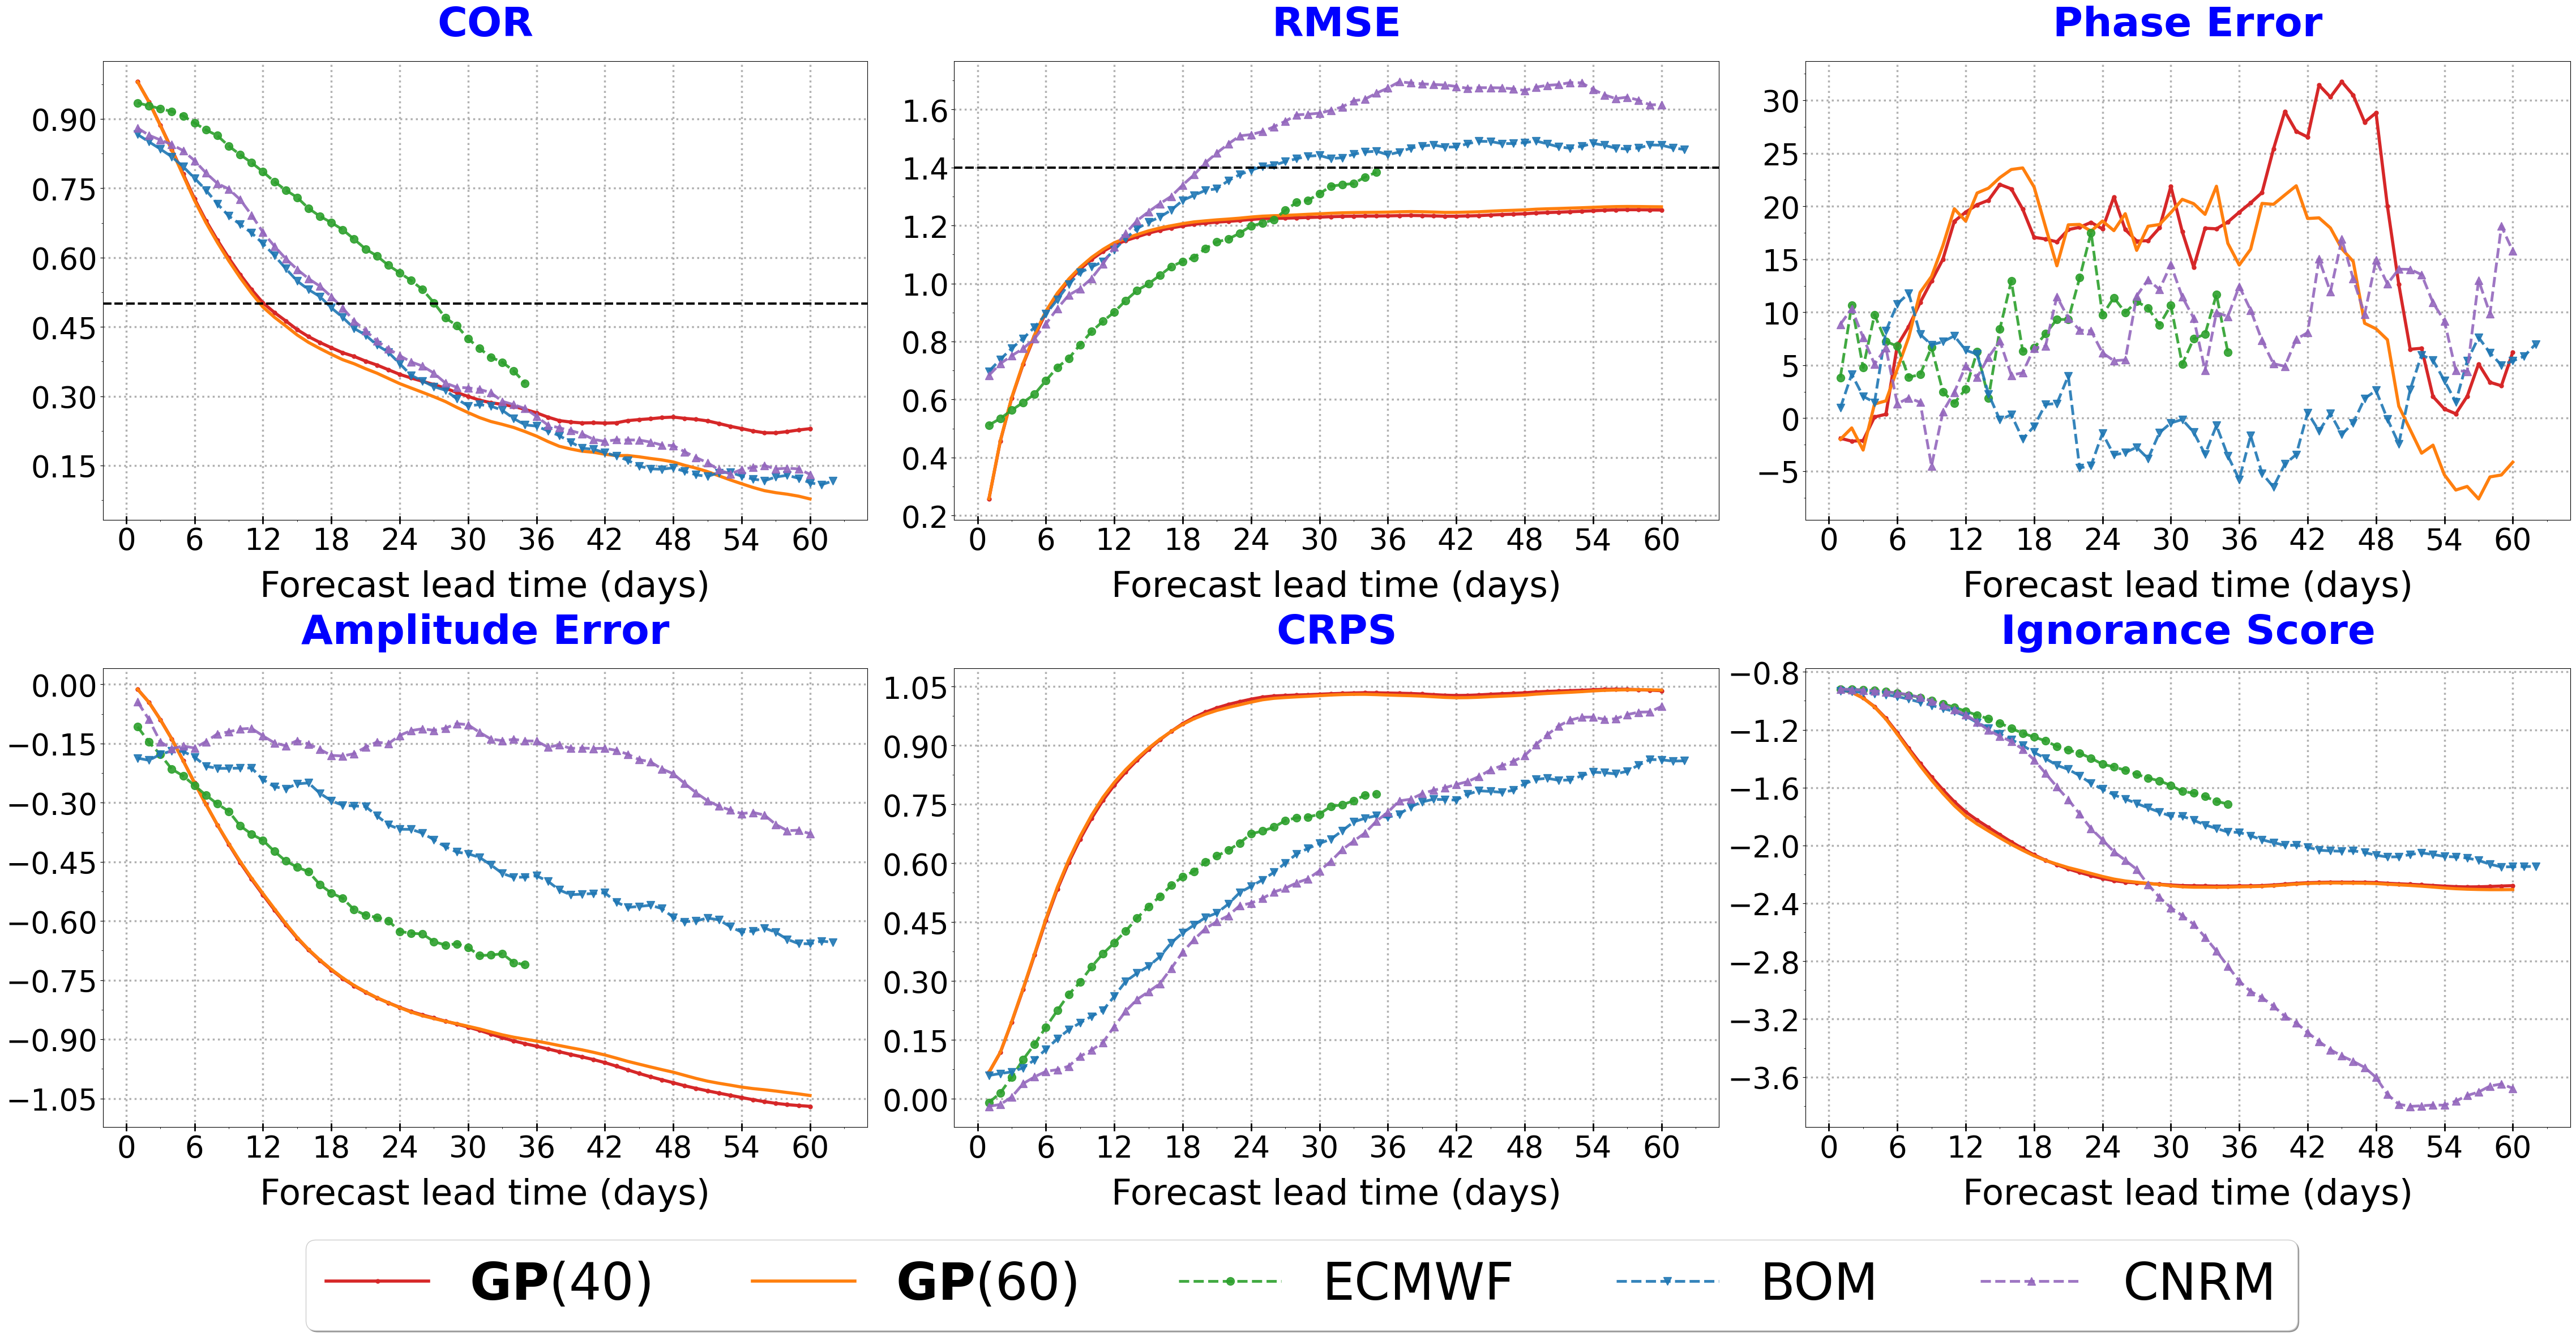

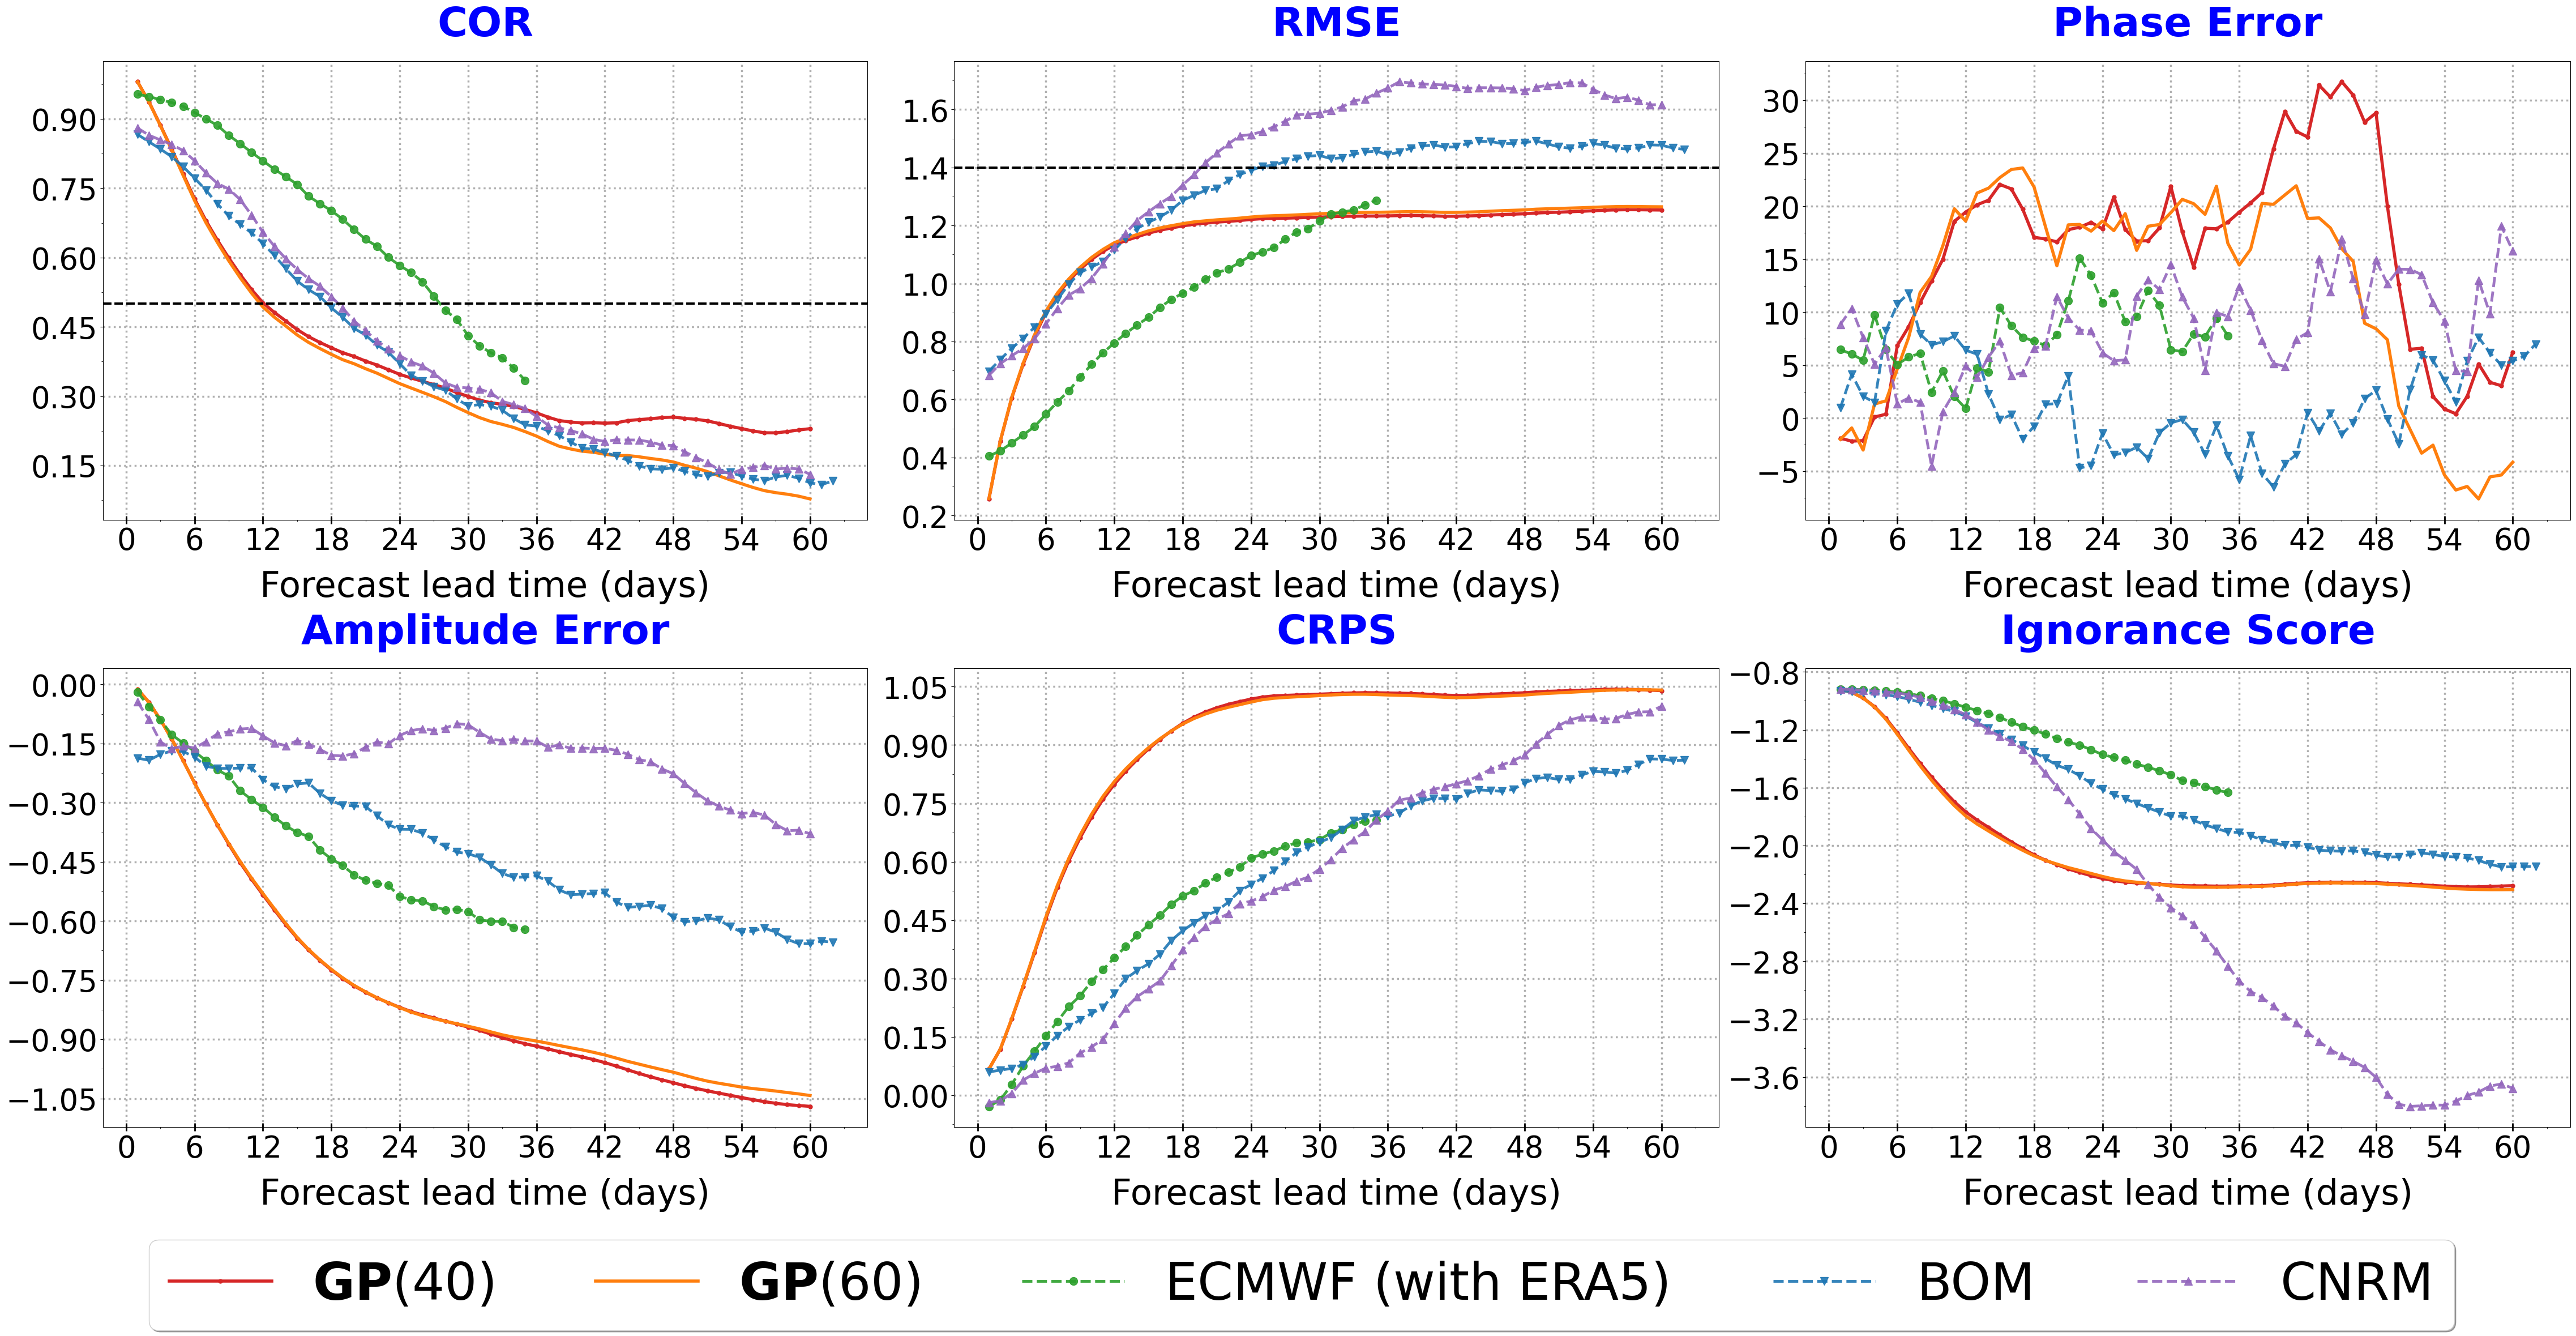

In [7]:
# np.argwhere( np.isnan( s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'][9][:, 0] ) ) #'hdate' = 9, 10,...,19, set lead_time=0
# only [[ 83], [888], [889], [890], [891],[892], [918]])-th pred is NaN when hdate = 9,10,...,19

dir_names = ['ecmwf_txt', 'bom', 'cnrm']

dir_lens = [0]* len(dir_names)
for i, dir_name in enumerate(dir_names):
    if dir_name == 'ecmwf_txt':
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean']['S'])
    else:
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['S'])

min_dir_len = min(dir_lens) # 528
min_dir_name = dir_names[dir_lens.index(min_dir_len)] # 'cnrm'

choose_dir_name = 'bom'
widths = [40,60]
n = 10000
v = 2000
m = 5000
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 528

model_clses=[FFNNModel]
nn_width = 60
hidden_dim = 64
num_epochs = 10
lr = 0.01
seed = 0

emp_pred_model = EmpGPMJOPred(npzfile=entire_npzfile, s2s_data=s2s_data, 
                choose_dir_name=choose_dir_name, widths=widths,
                n=n, v=v, m=m, lead_time=lead_time, n_pred=n_pred,
                start_train=start_train, n_offset=n_offset, min_dir_len=min_dir_len)
emp_pred_model.pred(test_on_choose_dir=False, test_ids=None)
for era5_obs in [False, True]:
    emp_pred_model.add_s2s(dir_names=dir_names, hdate_id=19, era5_obs=era5_obs, n_pred=n_pred)
    # emp_pred_model.add_nn(model_clses=[FFNNModel], width=nn_width, lead_time=lead_time, 
    #             hidden_dim=hidden_dim, num_epochs=num_epochs, lr=lr, seed=seed, verbose=False)
    emp_pred_model.plot_metrics(nrows=2, ncols=3, plot_skill=True)

### Auto-corr and Cross-corr

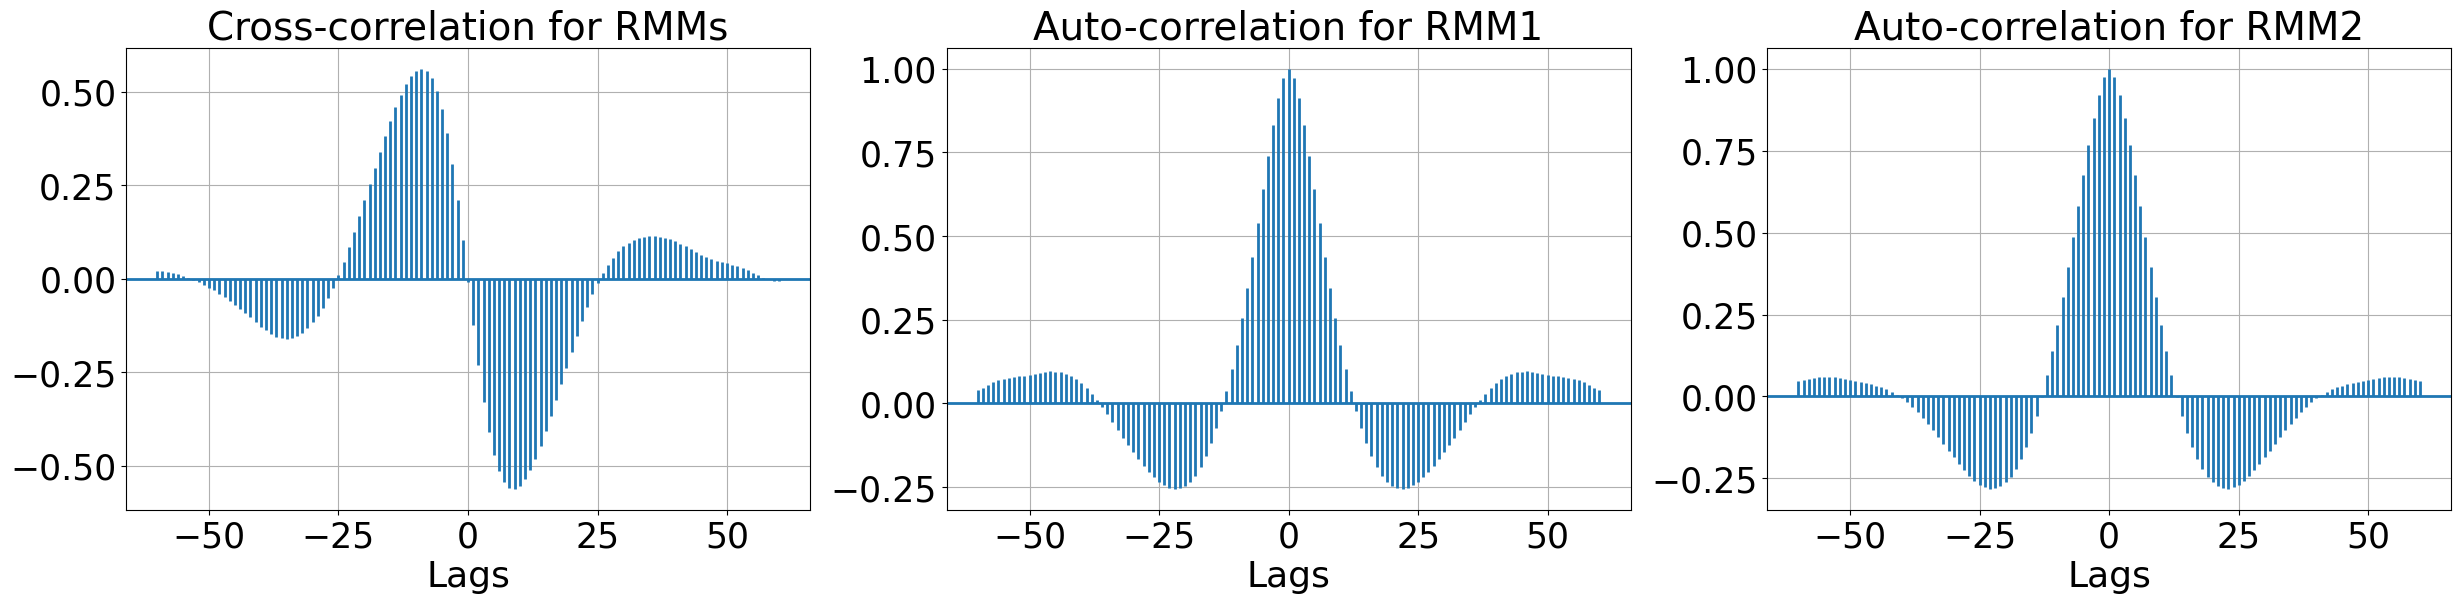

In [8]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
colors = palette_colors[0:len(widths)]
rmms = ['RMM1','RMM2']

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

# Plot auto-correlation and cross-correlation
maxlags = 60
n_trains = emp_pred_model.n_trains
fig, axs = plt.subplots(1, 3, figsize=(10*3, 6))
axs[0].xcorr(entire_npzfile['RMM1'][start_train: start_train+n_trains[widths[0]]], entire_npzfile['RMM2'][start_train: start_train+n_trains[widths[0]]], usevlines=True, normed=True, maxlags=maxlags, lw=2)
axs[0].set_xlabel('Lags', fontsize=26) #, fontweight='bold'
axs[0].set_title(f'Cross-correlation for RMMs', fontsize=28) # with maxlags = {maxlags}
axs[0].grid(True)
for k, rmm in enumerate(['RMM1','RMM2']):
    axs[k+1].acorr(entire_npzfile[rmm][start_train: start_train+n_trains[widths[0]]], usevlines=True, maxlags=maxlags, normed=True, lw=2)
    axs[k+1].set_xlabel('Lags', fontsize=26)
    axs[k+1].set_title(f'Auto-correlation for {rmm}', fontsize=28)
    #axs[k+1].set_title(f'Auto-correlation for {rmm} with maxlags = {maxlags}', fontsize=20)
    axs[k+1].grid(True)
fig.savefig("../figs/corrs/entire_corrs.png", bbox_inches='tight')

### HSS

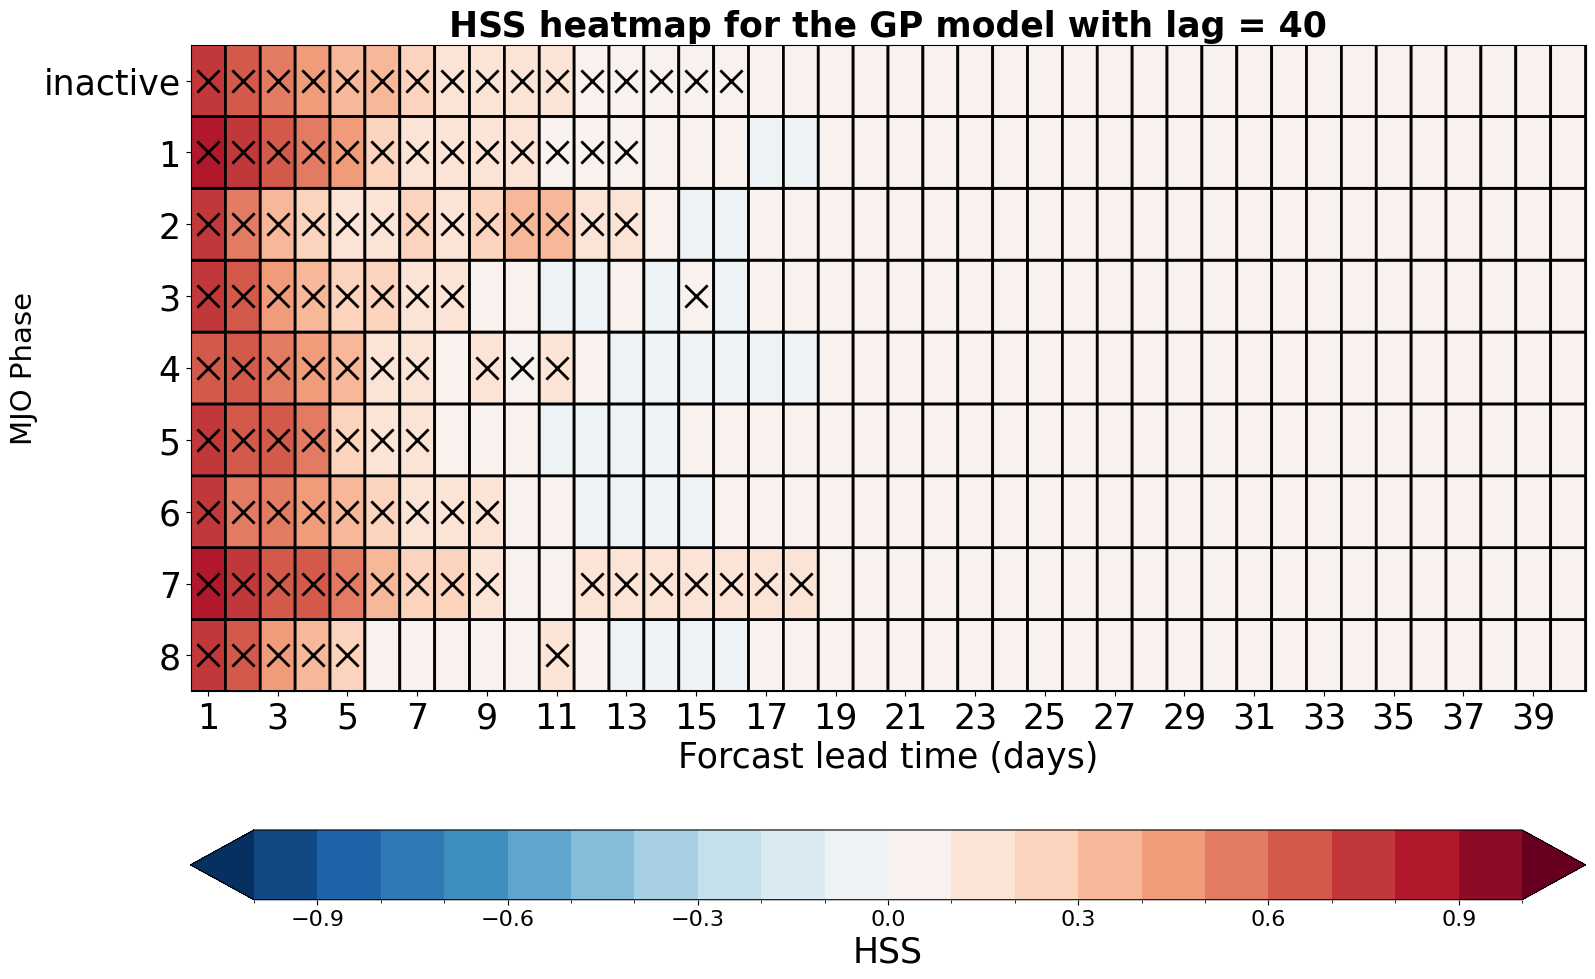

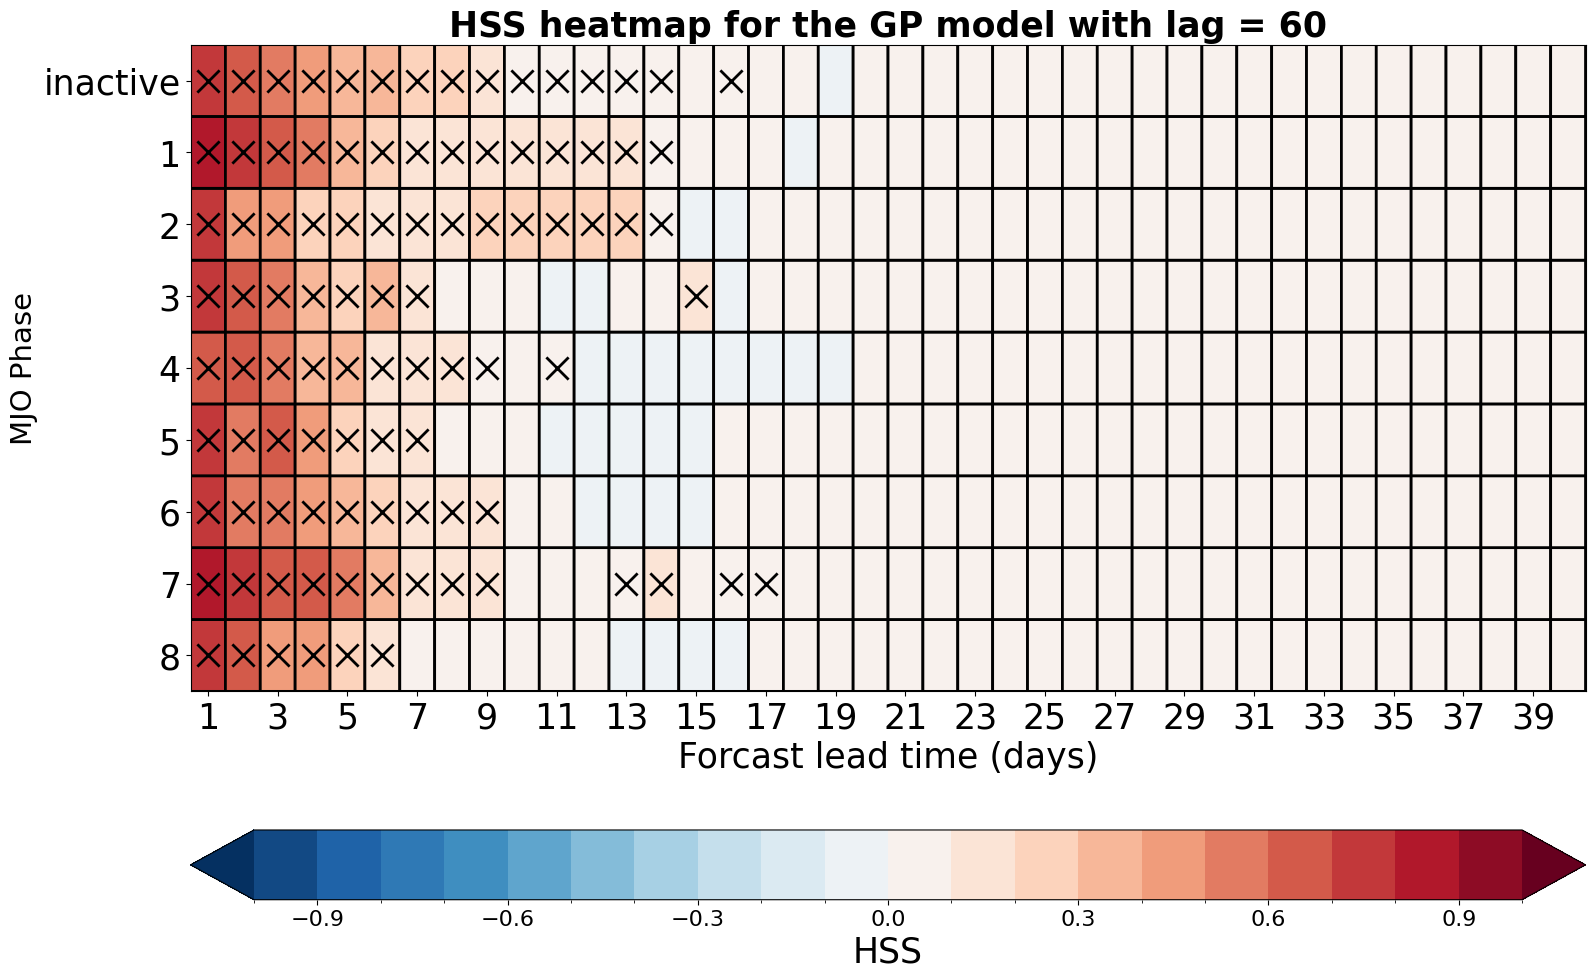

In [9]:
# Plot hss heatmap
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
lead_time_select = 40

hss_entire = emp_pred_model.hss_entire
hss_signif_entire = emp_pred_model.hss_signif_entire

for width_id, width in enumerate(widths):
    fig, ax = plt.subplots(1, 1, figsize = (18, 12))

    heatmap_data = hss_entire[width][:,:lead_time_select]
    bounds = np.linspace(-1, 1, 21)
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
    pcm = ax.pcolor(np.flip(heatmap_data, axis=0), norm=norm, cmap='RdBu_r', edgecolors='k', linewidths=2)

    # Set ticks in center of cells
    ax.set_xticks(np.arange(0,heatmap_data.shape[1],2) + 0.5, minor=False)
    ax.set_yticks(np.arange(0,heatmap_data.shape[0]) + 0.5, minor=False)

    # Rotate the xlabels. Set both x and y labels to headers[1:]
    xticklabels = np.arange(1, lead_time_select+1, 2)
    yticklabels = [i for i in np.flip(np.arange(1,9))] + ['inactive']
    ax.set_xticklabels(xticklabels, fontsize=25)
    ax.set_yticklabels(yticklabels, fontsize=25)

    # The colorbar inherits the "extend" argument from BoundaryNorm
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal')
    #cbar.ax.set_xticklabels( np.linspace(start=-1, stop=1, num=21, endpoint=True))
    cbar.set_label('HSS', size=25)
    ax.set_xlabel('Forcast lead time (days)', fontsize=25)
    ax.set_ylabel('MJO Phase', fontsize=21)
    ax.set_title(f'HSS heatmap for the GP model with lag = {width}', fontsize=25, fontweight="bold")

    xpos_signif = np.argwhere(np.flip(hss_signif_entire[width][:,:lead_time_select],axis=0) == 'X')[:,1] + 0.5
    ypos_signif = np.argwhere(np.flip(hss_signif_entire[width][:,:lead_time_select],axis=0) == 'X')[:,0] + 0.5
    ax.scatter(xpos_signif, ypos_signif, marker="x", color="black", s=256, linewidths=2)

    fig.savefig(f"../figs/hss/hss_lag{width}.png", bbox_inches='tight')
    plt.show()

### Phase Diagram

In [10]:
dir_names = ['ecmwf_txt', 'bom', 'cnrm']

dir_lens = [0]* len(dir_names)
for i, dir_name in enumerate(dir_names):
    if dir_name == 'ecmwf_txt':
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean']['S'])
    else:
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['S'])

min_dir_len = min(dir_lens) # 528
min_dir_name = dir_names[dir_lens.index(min_dir_len)] # 'cnrm'

choose_dir_name = 'bom'
widths = [40,60]
n = 10000
v = 2000
m = 5000
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 365*5

era5_obs=True

emp_pred_model = EmpGPMJOPred(npzfile=entire_npzfile, s2s_data=s2s_data, 
                choose_dir_name=choose_dir_name, widths=widths,
                n=n, v=v, m=m, lead_time=lead_time, n_pred=n_pred,
                start_train=start_train, n_offset=n_offset, min_dir_len=min_dir_len)
emp_pred_model.pred(test_on_choose_dir=False, test_ids=None)
emp_pred_model.add_s2s(dir_names=dir_names, hdate_id=19, era5_obs=era5_obs, n_pred=n_pred)

obs = emp_pred_model.obs
observed_preds = emp_pred_model.observed_preds
emp_model = emp_pred_model.emp_model

#### Figures

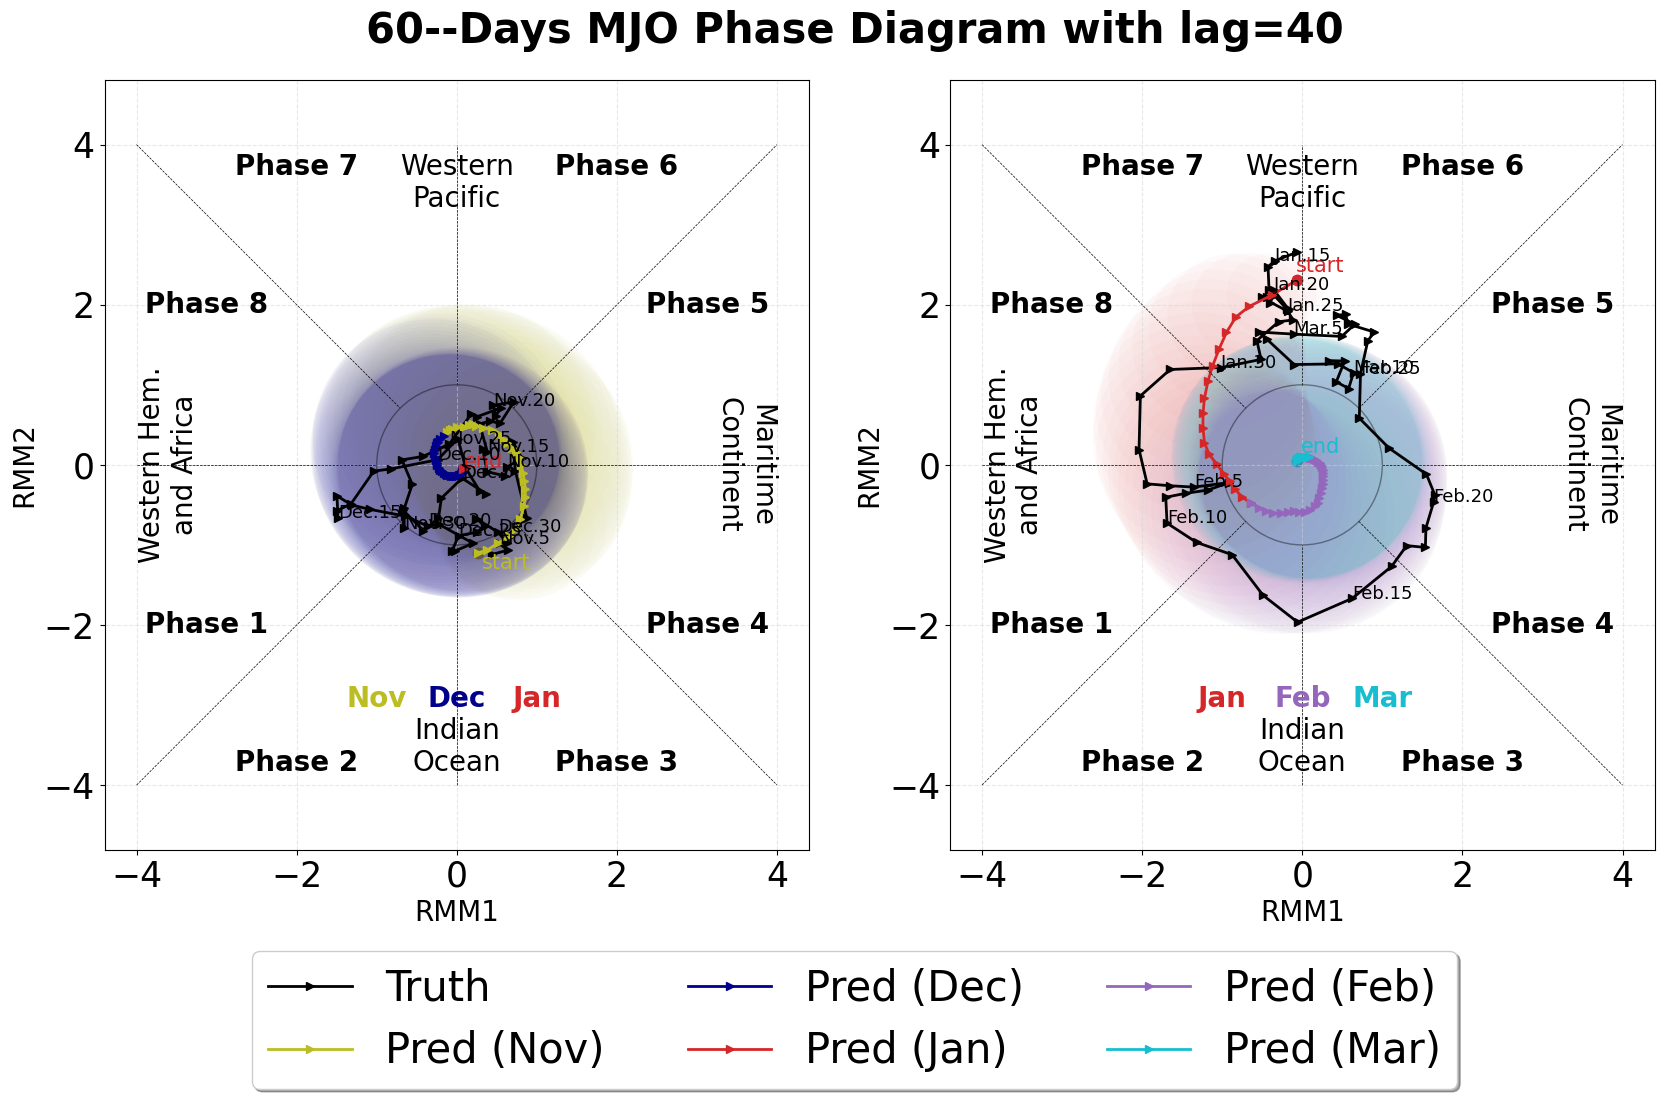

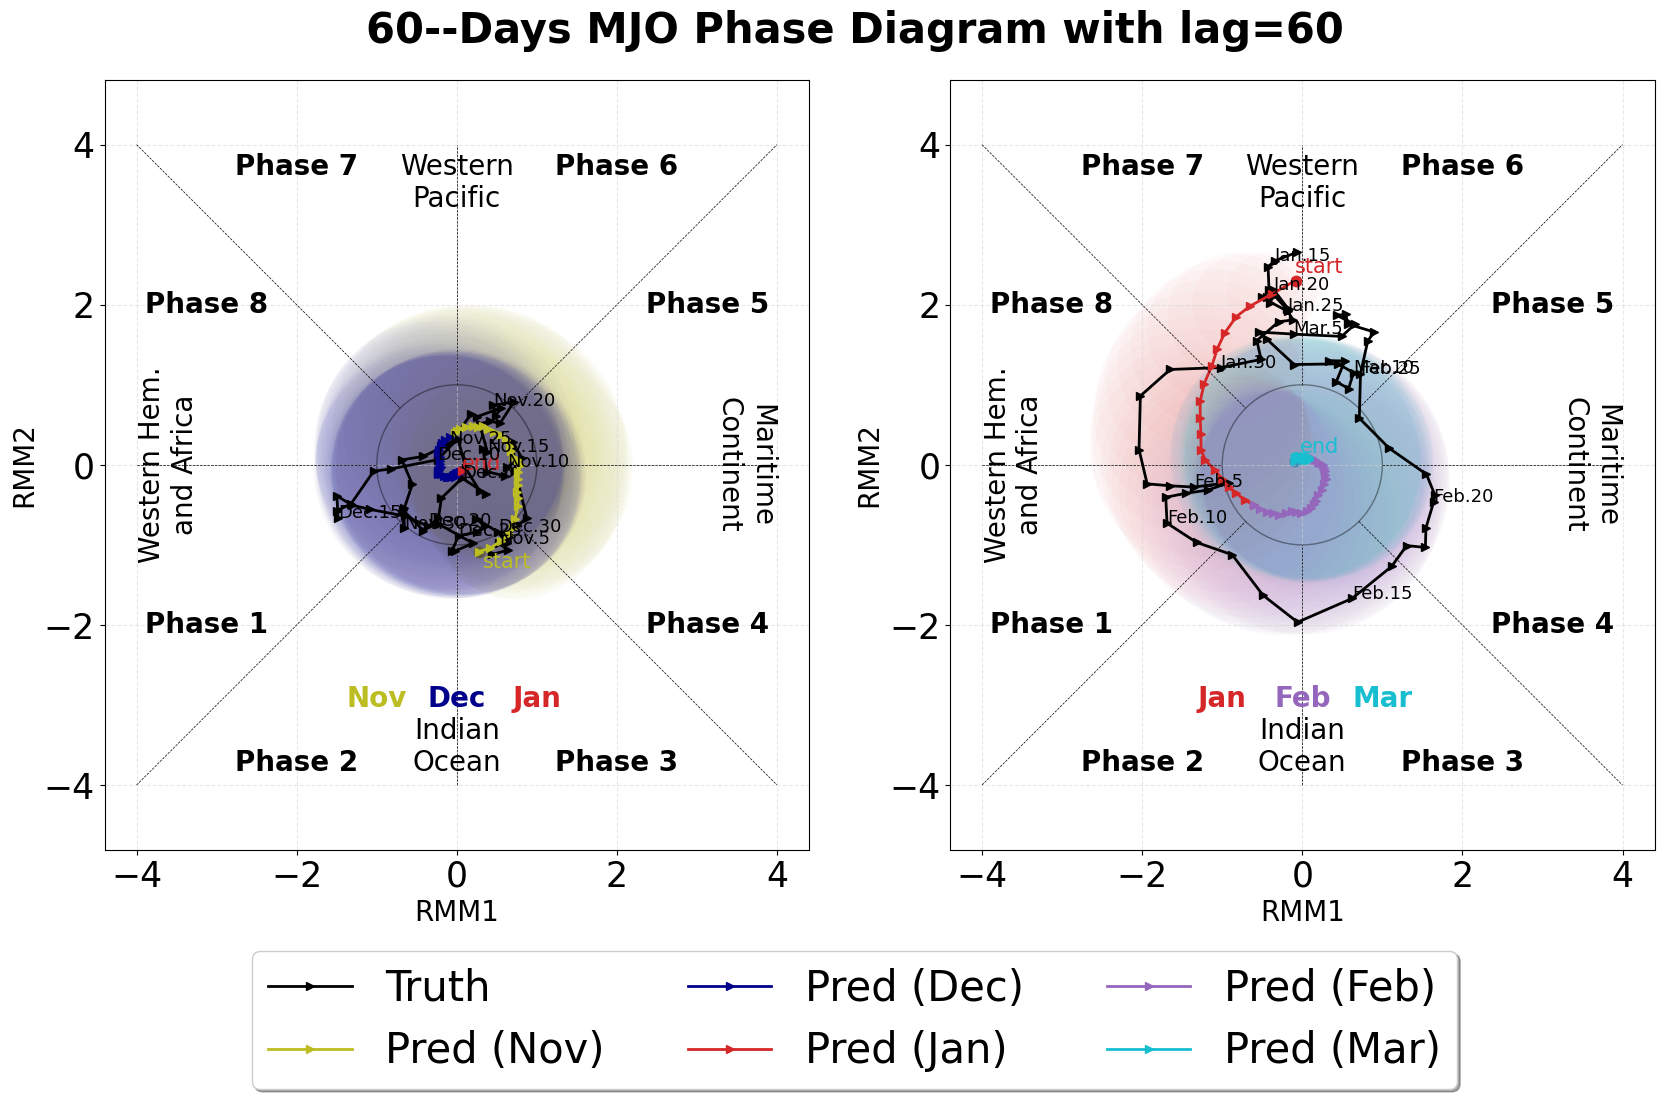

In [35]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:blue', 
                'gold','tab:green', 'tab:orange', 'hotpink', 'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id = 172 # 90, 172, 243, 302, 363, 394
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width_id, width in enumerate(widths):
    fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))
    for pred_id_id, pred_id in enumerate([172-2, 243-1]):
        ax = axs[pred_id_id]

        # dates of the time period for the plot
        start_year = obs[width]['year'][pred_id, 0].astype('int')
        start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
        start_day = obs[width]['day'][pred_id, 0].astype('int')
        start_date =  f'{start_month}-{start_day:02d}-{start_year}'

        end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
        end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
        end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
        end_date =  f'{end_month}-{end_day:02d}-{end_year}'

        months_temp, ind = np.unique(obs[width]['month'][pred_id, :], return_index=True)
        months = months_temp[np.argsort(ind)].astype('int')

        #fig, ax = plt.subplots(1, 1, figsize=(14, 14))

        ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="Truth")
        for month_id, month in enumerate(months):
            if len(months) == 2:
                    ax.text(-0.5 + 1 * month_id, -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=20, fontweight="bold")
            if len(months) == 3:
                    ax.text(0.0 + 1 * (month_id-1), -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=20, fontweight="bold")
            
            month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
            if month_id < len(months)-1:
                    month_ids_add = np.hstack(( month_ids, month_ids[-1]+1 ))
            else:
                    month_ids_add = month_ids
            ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids_add], observed_preds[width]['RMM2'][pred_id, month_ids_add], '->', color=month_colors[month-1], linewidth=2, label=f"Pred ({calendar.month_abbr[month]})")

        ax.scatter(observed_preds[width]['RMM1'][pred_id, 0], observed_preds[width]['RMM2'][pred_id, 0], marker='o', color=month_colors[months[0]-1], linewidths=2.5)
        ax.scatter(observed_preds[width]['RMM1'][pred_id, lead_time-1], observed_preds[width]['RMM2'][pred_id, lead_time-1], marker='o', color=month_colors[months[-1]-1], linewidths=2.5)
        if pred_id_id == 0:
                ax.text(observed_preds[width]['RMM1'][pred_id, 0]+0.05, observed_preds[width]['RMM2'][pred_id, 0]-0.2, 'start', color=month_colors[months[0]-1], fontsize = 15)
                ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.01, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.01, 'end', color=month_colors[months[-1]-1], fontsize = 15)

        if pred_id_id == 1:
                ax.text(observed_preds[width]['RMM1'][pred_id, 0]-0.01, observed_preds[width]['RMM2'][pred_id, 0]+0.1, 'start', color=month_colors[months[0]-1], fontsize = 15)
                ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.05, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.1, 'end', color=month_colors[months[-1]-1], fontsize = 15)

        for j in range(lead_time):
            pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
            true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
            pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
            rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
            rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
            rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

            eig_vals, eig_vecs = np.linalg.eig(pred_cov)
            eig_id_max = np.argmax(eig_vals)
            eig_id_min = np.argmin(eig_vals)

            #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
            
            month_j = (obs[width]['month'][pred_id, j]).astype('int')
            # ax.plot(pred_mean[0], pred_mean[1], '->', color=month_colors[month_j-1], linewidth=2, label="Predictive mean")
            # ax.plot(true_mean[0], true_mean[1], '->', color='black', linewidth=2, label="Truth")

            ell = patches.Ellipse(
            xy = (pred_mean[0], pred_mean[1]),
            width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
            height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
            angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
            alpha = 0.02,#0.035,
            #label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
            facecolor = month_colors[month_j-1]#'lightcoral',
            )
            ax.add_patch(ell)

            day = (obs[width]['day'][pred_id, j]).astype('int')
            if day % labelday == 0:
                    ax.text(obs[width]['RMM1'][pred_id, j], obs[width]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=13)
        #     if j == 0 and width_id==0:
        #             ax.legend(fontsize=20, loc='upper right')

            

        # lines to separate the phases  
        ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
        ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
        ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
        ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
        ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
        ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
        ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
        ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
        ax.set(xlim =(-4.0, 4.0), 
            ylim =(-4.0, 4.0), 
            autoscale_on = False)


        # circle in the center of the plot to denote weak index  
        circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
        ax.add_patch(circle)


        # text for phases
        ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
        fontsize=20) #transform=ax.transAxes, 
        ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
        fontsize=20, fontweight='bold')
        ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
        fontsize=20, fontweight='bold')

        ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
        fontsize=20)
        ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
        fontsize=20, weight='bold')#transform=ax.transAxes, 
        ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
        fontsize=20, weight='bold')

        ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
        rotation=-90, fontsize=20)
        ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
        fontsize=20, fontweight='bold')
        ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
        fontsize=20, fontweight='bold')

        ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
        rotation=90, fontsize=20)
        ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
        fontsize=20, weight='bold')
        ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
        fontsize=20, weight='bold')


        ax.axis("equal")
            #ax = plt.gca().add_artist(first_legend)
        ax.set_xlabel('RMM1', fontsize=20)
        ax.set_ylabel('RMM2', fontsize=20)
        # ax.set_title(f'{lead_time}--Days MJO Phase Diagram with lag={width}', fontsize=20, fontweight="bold")
        #ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=20, fontweight="bold")
        ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)
    

    unique_labels = {}
    for ax in fig.axes:
        lines, labels = ax.get_legend_handles_labels()
        for line, label in zip(lines, labels):
            if label not in unique_labels:
                unique_labels[label] = line
            # Prepare the final lines and labels for the legend
    final_lines = list(unique_labels.values())
    final_labels = list(unique_labels.keys())

    ncol_legend = 3
    fig.legend(final_lines, final_labels, fontsize=30, loc='lower center', bbox_to_anchor=(0.5, -0.15),
                ncol=ncol_legend , fancybox=True, shadow=True)
    fig.suptitle(f'{lead_time}--Days MJO Phase Diagram with lag={width}', 
                    fontsize=30, fontweight='bold', y=0.95)
    fig.savefig(f"../figs/phase_diagram/entire_mjo_phase_diag_example_lag{width}.png", bbox_inches='tight')
plt.show()


#### Videos

In [ ]:
## animation

palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:blue', 'gold','tab:green', 'tab:orange', 'hotpink',
    'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id = 363 # 90, 172, 243, 302, 363
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width in widths:

    # dates of the time period for the plot
    start_year = obs[width]['year'][pred_id, 0].astype('int')
    start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
    start_day = obs[width]['day'][pred_id, 0].astype('int')
    start_date =  f'{start_month}-{start_day:02d}-{start_year}'

    end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
    end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
    end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
    end_date =  f'{end_month}-{end_day:02d}-{end_year}'

    months_temp, ind = np.unique(obs[width]['month'][pred_id, :], return_index=True)
    months = months_temp[np.argsort(ind)].astype('int')

    fig, ax = plt.subplots(1, 1, figsize=(14, 14))

    # ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
    month_split_id = np.zeros(len(months)).astype('int')
    for month_id, month in enumerate(months):
        if len(months) == 2:
                ax.text(-0.5 + 1 * month_id, -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                color=month_colors[month-1], fontsize=25, fontweight="bold")
        if len(months) == 3:
                ax.text(0.0 + 1 * (month_id-1), -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                color=month_colors[month-1], fontsize=25, fontweight="bold")

        month_split_id[month_id] = np.where(obs[width]['month'][pred_id, :]== months[month_id])[0][-1] + 1
        
    #     month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
    #     ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids], observed_preds[width]['RMM2'][pred_id, month_ids], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")

    month_0 = (obs[width]['month'][pred_id, 0]).astype('int')
    ax_true = ax.plot(obs[width]['RMM1'][pred_id, 0], obs[width]['RMM2'][pred_id, 0], '-o', color='black', linewidth=2, label="truth")[0]
    ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, 0], observed_preds[width]['RMM2'][pred_id, 0], '-o', color=month_colors[month_0-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month_0]})")[0]
    ax.text(observed_preds[width]['RMM1'][pred_id, 0]-0.01, observed_preds[width]['RMM2'][pred_id, 0]+0.1, 'start', color=month_colors[months[0]-1], fontsize = 15)
    

    pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, 0] , observed_preds[width]['RMM2'][pred_id, 0] ] ) # (2, ) array
    true_mean = np.array( [ obs[width]['RMM1'][pred_id, 0] , obs[width]['RMM2'][pred_id, 0] ] ) # (2, ) array
    pred_cov = emp_model.Kcond_correct[0] # (2, 2) array
    rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
    rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
    rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

    eig_vals, eig_vecs = np.linalg.eig(pred_cov)
    eig_id_max = np.argmax(eig_vals)
    eig_id_min = np.argmin(eig_vals)

    #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
        

    ell = patches.Ellipse(
    xy = (pred_mean[0], pred_mean[1]),
    width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
    height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
    angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
    alpha = 0.035,
    label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
    facecolor = month_colors[month_0-1]#'lightcoral',
    )
    ax_cg = ax.add_patch(ell)
    #ax.legend(fontsize=25)
            

    # lines to separate the phases  
    ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
    ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
    ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
    ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
    ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
    ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
    ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
    ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
    ax.set(xlim =(-4.0, 4.0), 
        ylim =(-4.0, 4.0), 
        autoscale_on = False)


    # circle in the center of the plot to denote weak index  
    circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
    ax.add_patch(circle)


    # text for phases
    ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
    fontsize=25) #transform=ax.transAxes, 
    ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
    fontsize=25, fontweight='bold')
    ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
    fontsize=25, fontweight='bold')

    ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25)
    ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25, weight='bold')#transform=ax.transAxes, 
    ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25, weight='bold')

    ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
    rotation=-90, fontsize=25)
    ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
    fontsize=25, fontweight='bold')
    ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
    fontsize=25, fontweight='bold')

    ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
    rotation=90, fontsize=25)
    ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
    fontsize=25, weight='bold')
    ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
    fontsize=25, weight='bold')


    ax.axis("equal")
        #ax = plt.gca().add_artist(first_legend)
    ax.set_xlabel('RMM1', fontsize=25)
    ax.set_ylabel('RMM2', fontsize=25)
    ax.set_title(f'{lead_time}--Days MJO Phase Diagram with lag={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=25, fontweight="bold")
    ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)


    def update(j):
    #for j in range(lead_time):
        month_j = (obs[width]['month'][pred_id, j]).astype('int')

        ax_true = ax.plot(obs[width]['RMM1'][pred_id, :j], obs[width]['RMM2'][pred_id, :j], '->', color='black', linewidth=2, label="truth")[0]
        if j < month_split_id[0]:
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, :j], observed_preds[width]['RMM2'][pred_id, :j], '->', color=month_colors[month_j-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month_j]})")[0]
        elif month_split_id[0] <= j < month_split_id[1]:
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, :month_split_id[0]+1], observed_preds[width]['RMM2'][pred_id, :month_split_id[0]+1], '->', color=month_colors[months[0]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[0]]})")[0]
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, month_split_id[0]:j], observed_preds[width]['RMM2'][pred_id, month_split_id[0]:j], '->', color=month_colors[months[1]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[1]]})")[0]
        elif len(months) == 3 and j >= month_split_id[1]:
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, :month_split_id[0]+1], observed_preds[width]['RMM2'][pred_id, :month_split_id[0]+1], '->', color=month_colors[months[0]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[0]]})")[0]
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, month_split_id[0]:month_split_id[1]+1], observed_preds[width]['RMM2'][pred_id, month_split_id[0]:month_split_id[1]+1], '->', color=month_colors[months[1]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[1]]})")[0]
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, month_split_id[1]:j], observed_preds[width]['RMM2'][pred_id, month_split_id[1]:j], '->', color=month_colors[months[2]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[2]]})")[0]
              

        # # update true observation plot
        # ax_true.set_xdata(obs[width]['RMM1'][pred_id, :j])
        # ax_true.set_ydata(obs[width]['RMM2'][pred_id, :j])
        # ax_pred_mean.set_xdata(observed_preds[width]['RMM1'][pred_id, :j])
        # ax_pred_mean.set_ydata(observed_preds[width]['RMM2'][pred_id, :j])

        pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
        rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
        rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
        rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

        eig_vals, eig_vecs = np.linalg.eig(pred_cov)
        eig_id_max = np.argmax(eig_vals)
        eig_id_min = np.argmin(eig_vals)

        ##ax_samples.set_offsets(  )
        #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
        

        ell = patches.Ellipse(
        xy = (pred_mean[0], pred_mean[1]),
        width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
        height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
        angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
        alpha = 0.035,
        label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
        facecolor = month_colors[month_j-1]#'lightcoral',
        )
        ax_cg = ax.add_patch(ell)

        day = (obs[width]['day'][pred_id, j]).astype('int')
        if day % labelday == 0:
                ax.text(obs[width]['RMM1'][pred_id, j], obs[width]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=15)
        if j == lead_time-1:
            ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.05, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.05, 'end', color=month_colors[months[-1]-1], fontsize = 15) # color=month_colors[months[-1]-1]

    anim = animation.FuncAnimation(fig=fig, func=update, frames=lead_time, interval=0.5*1000, blit = False)
    #plt.show()
    # saving to m4 using ffmpeg writer
    writervideo = animation.FFMpegWriter(fps=1/0.5)
    anim.save(f'../videos/phase_diagram_width{width}_{start_month}-{end_month}.mp4', writer=writervideo)
    plt.close()

## Previous Plots

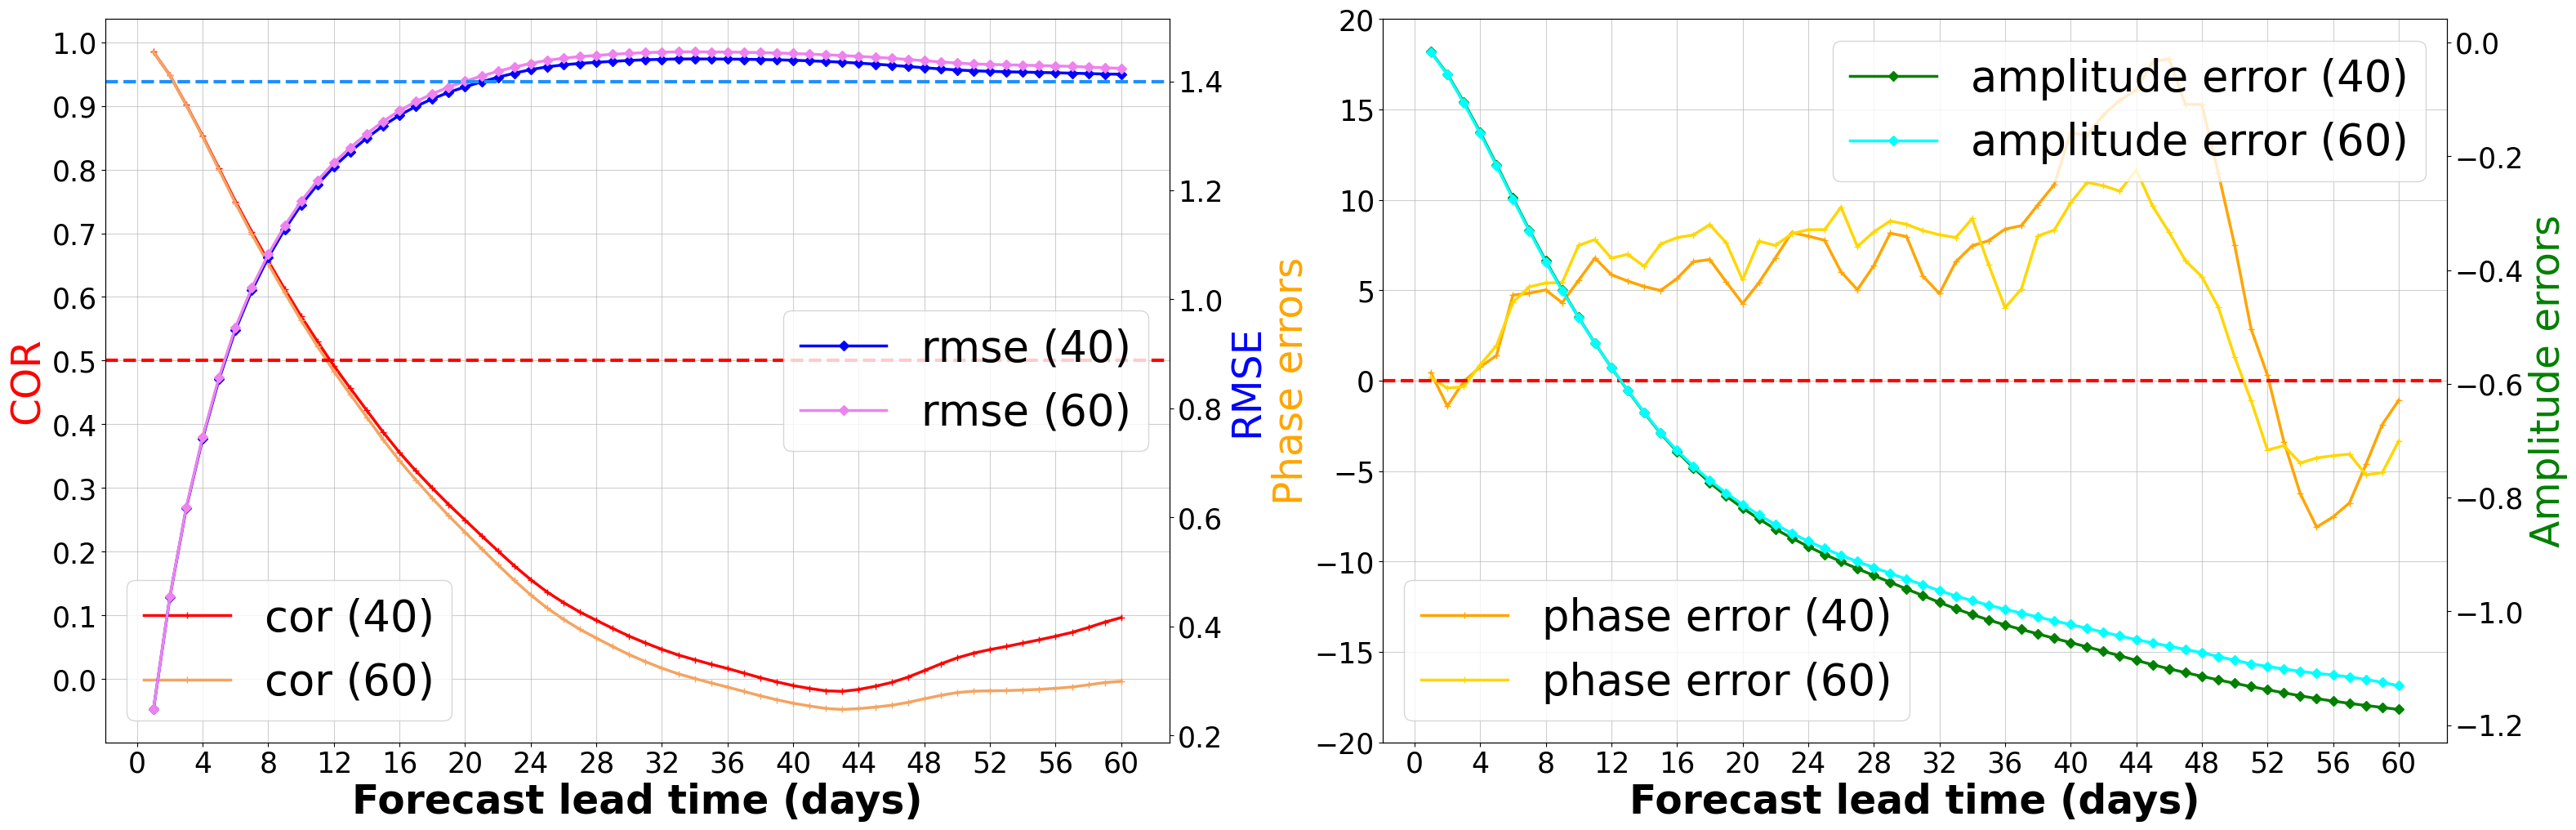

In [12]:
plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

cor_entire = emp_pred_model.cor_entire
rmse_entire = emp_pred_model.rmse_entire
phase_err_entire = emp_pred_model.phase_err_entire
amplitude_err_entire = emp_pred_model.amplitude_err_entire

# Plot errors
fig, axs = plt.subplots(1, 2, figsize=(18.5*2, 11.5))

# cor & rmse
cor_colors = ['red','sandybrown']
rmse_colors = ['blue','violet']
ax0 = axs[0].twinx()
for width_id, width in enumerate(widths):

    axs[0].plot(np.arange(1,lead_time+1), cor_entire[width], color=cor_colors[width_id], linewidth=2.5, marker='+', label=f'cor ({width})')
    ax0.plot(np.arange(1,lead_time+1), rmse_entire[width], color=rmse_colors[width_id], linewidth=2.5, marker='D', label=f'rmse ({width})')
    
axs[0].axhline(y = 0.5, color = 'r', linestyle = '--')
ax0.axhline(y = 1.4, color = 'dodgerblue', linestyle = '--')
axs[0].set_xlabel('Forecast lead time (days)', fontsize=35, fontweight="bold")
axs[0].set_ylabel('COR', color= 'red', fontsize=35)
#axs[0].set_title(f'COR & RMSE for Empirical GP Inference with \n training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")
ax0.set_ylabel('RMSE', color = 'blue', fontsize=35)
axs[0].legend(fontsize=38, loc='lower left')
ax0.legend(fontsize=38, loc='center right')

major_ticks = np.linspace(0, lead_time, 16)
minor_ticks = np.linspace(0.0, 1.0, 11)
axs[0].set_xticks(major_ticks)
axs[0].set_yticks(minor_ticks)
axs[0].grid(which="major",alpha=0.6)

# phase err & amplitude err
phase_err_colors = ['orange','gold']
amplitude_err_colors = ['green','cyan']
ax1 = axs[1].twinx()
for width_id, width in enumerate(widths):
    axs[1].plot(np.arange(1,lead_time+1), phase_err_entire[width], color=phase_err_colors[width_id], linewidth=2.5, marker='+', label=f'phase error ({width})')
    ax1.plot(np.arange(1,lead_time+1), amplitude_err_entire[width], color=amplitude_err_colors[width_id], linewidth=2.5, marker='D', label=f'amplitude error ({width})')

axs[1].axhline(y = 0.0, color = 'r', linestyle = '--')
axs[1].set_xlabel('Forecast lead time (days)', fontsize=35, fontweight="bold")
axs[1].set_ylabel('Phase errors', color='orange', fontsize=35)
#axs[1].set_title(f'Phase & Ampltidue errors for Empirical GP Inference with \n training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")
ax1.set_ylabel('Amplitude errors', color='green', fontsize=35)
axs[1].legend(fontsize=38, loc='lower left')
ax1.legend(fontsize=38, loc='upper right')

major_ticks = np.linspace(0, lead_time, 16)#31
minor_ticks = np.linspace(-20, 20, 9)
axs[1].set_xticks(major_ticks)
axs[1].set_yticks(minor_ticks)
axs[1].grid(which="major",alpha=0.6)

fig.savefig("../figs/metrics/entire_errs.png", bbox_inches='tight')
plt.show()

In [ ]:
# palette_colors = list(mcolors.TABLEAU_COLORS.keys())
# month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:blue', 'gold','tab:green', 'tab:orange', 'hotpink',
#     'tab:olive', 'darkblue']
# labelday = 5  # label every fifth day

# # plt.rc("text", usetex=True)
# # plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

# plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

# Ns = 1000
# pred_id = 172 # 90, 172, 243, 302, 363, 394
# lead_time = 60

# p = 2
# alpha = 1-0.68
# s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

# fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))
# for width_id, width in enumerate(widths):
#       ax = axs[width_id]

#       # dates of the time period for the plot
#       start_year = obs[width]['year'][pred_id, 0].astype('int')
#       start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
#       start_day = obs[width]['day'][pred_id, 0].astype('int')
#       start_date =  f'{start_month}-{start_day:02d}-{start_year}'

#       end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
#       end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
#       end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
#       end_date =  f'{end_month}-{end_day:02d}-{end_year}'

#       months_temp, ind = np.unique(obs[width]['month'][pred_id, :], return_index=True)
#       months = months_temp[np.argsort(ind)].astype('int')

#       #fig, ax = plt.subplots(1, 1, figsize=(14, 14))

#       ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
#       for month_id, month in enumerate(months):
#             if len(months) == 2:
#                   ax.text(-0.5 + 1 * month_id, -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
#                     color=month_colors[month-1], fontsize=20, fontweight="bold")
#             if len(months) == 3:
#                   ax.text(0.0 + 1 * (month_id-1), -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
#                     color=month_colors[month-1], fontsize=20, fontweight="bold")
            
#             month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
#             if month_id < len(months)-1:
#                   month_ids_add = np.hstack(( month_ids, month_ids[-1]+1 ))
#             else:
#                   month_ids_add = month_ids
#             ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids_add], observed_preds[width]['RMM2'][pred_id, month_ids_add], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")

#       ax.scatter(observed_preds[width]['RMM1'][pred_id, 0], observed_preds[width]['RMM2'][pred_id, 0], marker='o', color=month_colors[months[0]-1], linewidths=2.5)
#       ax.text(observed_preds[width]['RMM1'][pred_id, 0]-0.01, observed_preds[width]['RMM2'][pred_id, 0]+0.1, 'start', color=month_colors[months[0]-1], fontsize = 15)
#       ax.scatter(observed_preds[width]['RMM1'][pred_id, lead_time-1], observed_preds[width]['RMM2'][pred_id, lead_time-1], marker='o', color=month_colors[months[-1]-1], linewidths=2.5)
#       ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.05, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.1, 'end', color=month_colors[months[-1]-1], fontsize = 15)

#       for j in range(lead_time):
#             pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
#             true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
#             pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
#             rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
#             rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
#             rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

#             eig_vals, eig_vecs = np.linalg.eig(pred_cov)
#             eig_id_max = np.argmax(eig_vals)
#             eig_id_min = np.argmin(eig_vals)

#             #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
            
#             month_j = (obs[width]['month'][pred_id, j]).astype('int')
#             # ax.plot(pred_mean[0], pred_mean[1], '->', color=month_colors[month_j-1], linewidth=2, label="Predictive mean")
#             # ax.plot(true_mean[0], true_mean[1], '->', color='black', linewidth=2, label="Truth")

#             ell = patches.Ellipse(
#             xy = (pred_mean[0], pred_mean[1]),
#             width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
#             height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
#             angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
#             alpha = 0.02,#0.035,
#             #label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
#             facecolor = month_colors[month_j-1]#'lightcoral',
#             )
#             ax.add_patch(ell)

#             day = (obs[width]['day'][pred_id, j]).astype('int')
#             if day % labelday == 0:
#                   ax.text(obs[width]['RMM1'][pred_id, j], obs[width]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=13)
#             if j == 0 and width_id==0:
#                   ax.legend(fontsize=20, loc='upper right')

            

#       # lines to separate the phases  
#       ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
#       ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
#       ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
#       ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
#       ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
#       ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
#       ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
#       ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
#       ax.set(xlim =(-4.0, 4.0), 
#             ylim =(-4.0, 4.0), 
#             autoscale_on = False)


#       # circle in the center of the plot to denote weak index  
#       circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
#       ax.add_patch(circle)


#       # text for phases
#       ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
#       fontsize=20) #transform=ax.transAxes, 
#       ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
#       fontsize=20, fontweight='bold')
#       ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
#       fontsize=20, fontweight='bold')

#       ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
#       fontsize=20)
#       ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
#       fontsize=20, weight='bold')#transform=ax.transAxes, 
#       ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
#       fontsize=20, weight='bold')

#       ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
#       rotation=-90, fontsize=20)
#       ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
#       fontsize=20, fontweight='bold')
#       ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
#       fontsize=20, fontweight='bold')

#       ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
#       rotation=90, fontsize=20)
#       ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
#       fontsize=20, weight='bold')
#       ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
#       fontsize=20, weight='bold')


#       ax.axis("equal")
#             #ax = plt.gca().add_artist(first_legend)
#       ax.set_xlabel('RMM1', fontsize=20)
#       ax.set_ylabel('RMM2', fontsize=20)
#       ax.set_title(f'{lead_time}--Days MJO Phase Diagram with lag={width}', fontsize=20, fontweight="bold")
#       #ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=20, fontweight="bold")
#       ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)
# plt.show()